## MLPerf Training/HPC results visualization

## Choose benchmark

In [1]:
from collections import namedtuple
MLPerfBenchmark = namedtuple('MLPerfBenchmark',['round','name'])

In [2]:
# Choose benchmark to visualize

# benchmark = MLPerfBenchmark(round='training_results_v0.7', name='resnet') 
benchmark = MLPerfBenchmark(round='hpc_results_v0.7', name='cosmoflow') 
# benchmark = MLPerfBenchmark(round='hpc_results_v0.7', name='deepcam')

In [3]:
# paths of results repos
import json
with open('mlperf_results_paths.json', 'r') as results_paths_f:
    mlperf_results_dirs = json.load(results_paths_f)

## Parse results

In [4]:
import glob
import re
import os
import subprocess
import math
import functools
import inspect
import numpy as np
from pprint import pprint
from IPython.display import display

In [5]:
benchmark_results_dir = mlperf_results_dirs[benchmark.round]
mlperf_results_dirs[benchmark.round]

'../hpc_results_v0.7/'

In [6]:
benchmark_submissions = glob.glob( os.path.join(benchmark_results_dir, '*/results/*/' + benchmark.name) )
benchmark_submissions

['../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow',
 '../hpc_results_v0.7/Fujitsu/results/fugaku_16384xA64FX_tensorflow_open/cosmoflow',
 '../hpc_results_v0.7/Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow',
 '../hpc_results_v0.7/Fujitsu/results/abci_512xV100_tensorflow_closed/cosmoflow',
 '../hpc_results_v0.7/RIKEN/results/fugaku_512xA64FX_tensorflow_closed/cosmoflow',
 '../hpc_results_v0.7/CSCS/results/daint_gpu_n256_tf2.2.0/cosmoflow',
 '../hpc_results_v0.7/CSCS/results/daint_gpu_n128_tf2.2.0/cosmoflow',
 '../hpc_results_v0.7/NCSA/results/halv100_n16_tf1.15.0/cosmoflow',
 '../hpc_results_v0.7/LBNL/results/coriknl_n512_tf1.15.2/cosmoflow',
 '../hpc_results_v0.7/LBNL/results/coriknl_n1024_tf1.15.2/cosmoflow',
 '../hpc_results_v0.7/LBNL/results/corigpu_n64_tf1.15.0/cosmoflow',
 '../hpc_results_v0.7/TACC/results/frontera_rtx_n16_tf1.15.2_lbs1/cosmoflow']

In [7]:
# %%bash
# ls $(pwd)/${benchmark_results_dir}/*/systems/

In [8]:
# # Check and move Alibaba results for consistency
# %%bash

# ls $(pwd)/${benchmark_results_dir}/Alibaba/results/n1_A100/resnet 
# #git mv Alibaba/results/n1_A100/resnet/{200711025203744603517_5.log,result_5.txt}

In [9]:
mlperf_opts = {
    'training_results_v0.7': {},
    'hpc_results_v0.7': {},
}

In [10]:
# MLPerf Training ResNet hyperparameters
mlperf_opts['training_results_v0.7']['resnet'] = {
    
    # global_batch_size

    # opt_name can be lars or sgd for closed

    'opt_opts_names' : dict(
        lars=\
        ['lars_opt_base_learning_rate',
         'lars_opt_end_learning_rate',
         'lars_opt_learning_rate_decay_poly_power',
         'lars_epsilon',
         'lars_opt_learning_rate_warmup_epochs',
         'lars_opt_momentum',
         'lars_opt_weight_decay',
         'lars_opt_learning_rate_decay_steps'],
        sgd=\
        ['sgd_opt_base_learning_rate',
         'sgd_opt_end_learning_rate',
         'sgd_opt_learning_rate_decay_poly_power',
         'sgd_opt_learning_rate_decay_steps',
         'sgd_opt_weight_decay',
         'sgd_opt_momentum',
         'model_bn_span',
         'opt_learning_rate_warmup_epochs']
    ),
    'runs_to_submit' : 5,
    'eval_target_key': 'eval_accuracy',
} 

In [11]:
# # Extra parameters
# staging_start 
# staging_stop

In [12]:
# MLPerf HPC Cosmoflow hyperparameters
mlperf_opts['hpc_results_v0.7']['cosmoflow'] = {

    # global_batch_size

    # opt_name must be SGD for closed

    'opt_opts_names' : dict(
        SGD=\
        ['sgd_opt_momentum',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_epochs',
         'opt_learning_rate_warmup_factor',
         'opt_learning_rate_decay_boundary_epochs',
         'opt_learning_rate_decay_factor']
    ),
    'runs_to_submit' : 10,
    'eval_target_key': 'eval_error',
}

In [13]:
# MLPerf HPC DeepCAM hyperparameters

mlperf_opts['hpc_results_v0.7']['deepcam'] = {

    # global_batch_size

    # opt_name must be AdamW or LAMB  for closed

    'opt_opts_names' : dict(
        AdamW=\
        ['opt_epsilon',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_steps',
         'opt_learning_rate_warmup_factor',
         'opt_learning_rate_decay_steps',
         'opt_learning_rate_decay_factor',
         'opt_weight_decay',
        ],
        LAMB=\
        ['opt_epsilon',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_steps',
         'opt_learning_rate_warmup_factor',
         'opt_weight_decay',
        ]
#         'validation_frequency', fixed to 100
#         'loss_weight_pow'       fixed to -0.125
    ),
    
    'runs_to_submit' : 5,
    'eval_target_key': 'eval_accuracy',
}

In [14]:
template_pattern = r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'

train_samples_pattern =  re.compile(template_pattern.format('train_samples'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_samples_pattern  =  re.compile(template_pattern.format('eval_samples'),  re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission

block_start_pattern =  re.compile(template_pattern.format('block_start'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
epoch_start_pattern =  re.compile(template_pattern.format('epoch_start'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_start_pattern  =  re.compile(template_pattern.format('eval_start' ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_stop_pattern   =  re.compile(template_pattern.format('eval_stop'  ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_target_pattern   =  re.compile(template_pattern.format(mlperf_opts[benchmark.round][benchmark.name]['eval_target_key']), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
epoch_stop_pattern  =  re.compile(template_pattern.format('epoch_stop' ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
block_stop_pattern  =  re.compile(template_pattern.format('block_stop' ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission

if benchmark.round == 'hpc_results_v0.7':
    staging_start_pattern  =  re.compile(template_pattern.format('staging_start' ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
    staging_stop_pattern   =  re.compile(template_pattern.format('staging_stop'  ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
    

# Optimizer/hyperparameters
global_batch_size_pattern =  re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format('global_batch_size'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
opt_name_pattern =           re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format('opt_name'), re.M)

opt_patterns = { 
    opt_name:  { k: re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format(k), re.M) 
              for k in mlperf_opts[benchmark.round][benchmark.name]['opt_opts_names'][opt_name] }
    for opt_name in mlperf_opts[benchmark.round][benchmark.name]['opt_opts_names']
}

# Epochs to convergence
run_start_pattern =        re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$'.format('run_start'), re.M)
run_stop_pattern =         re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$'.format('run_stop'), re.M)

last_eval_target_pattern = re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]+?"key":[\s]*?"{}"[\s\S]+'.format(mlperf_opts[benchmark.round][benchmark.name]['eval_target_key'], 'run_stop'), re.M)

In [15]:
# # Testing
# print("asdf \n fdasqwer")
# result = re.compile('[\s\S]+^ (fdasqwer) $[\s\S]+', re.M).match("asdf \n fdasqwer \n 1234")
# print(result.group(0))

In [16]:
# %%bash
# grep sgd_opt_momentum $(pwd)/${benchmark_results_dir}/Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow/*

In [17]:
submissions_stats = dict()
for submission in benchmark_submissions: 

    print(submission, flush=True)
    submitter = submission.split('/')[-4]
    system_name  = submission.split('/')[-2]
    with open(os.path.join('/'.join(submission.split('/')[:-3]), 'systems', system_name + '.json'), 'r') as system_desc_file:
        system_desc = json.load(system_desc_file)
        system_desc['division'] = system_desc['division'].lower()
        if not system_desc['division'] in ['open', 'closed']:
            print(f'Erroneous division {system_desc["division"]} in system description of {submitter}!')
    submission_results = glob.glob(submission + '/result*')
    results = []
    for result in submission_results:

        if benchmark.round == 'training_results_v0.7':
            # block times
            block_start_content = subprocess.run(['/bin/grep', 'block_start', result], capture_output=True).stdout.decode('utf-8')
            block_starts = [json.loads(block_start_pattern.search(l).group(1)) for l in block_start_content.split('\n') if len(l) > 0]

            block_stop_content = subprocess.run(['/bin/grep', 'block_stop', result], capture_output=True).stdout.decode('utf-8')
            block_stops = [json.loads(block_stop_pattern.search(l).group(1)) for l in block_stop_content.split('\n') if len(l) > 0]

            if not( len(block_starts) == len(block_stops) ):
                print(f"Skipping {result} due to non-closed epoch interval...")
                continue
            if 'SIAT' not in submission:
                for i in range(len(block_starts)):
                    assert block_starts[i]['metadata']['first_epoch_num'] == block_stops[i]['metadata']['first_epoch_num']
                    if 'epoch_count' in block_stops[i]['metadata']:
                        assert block_starts[i]['metadata']['epoch_count'] == block_stops[i]['metadata']['epoch_count']
                    if i > 0:
                        block_starts[i-1]['metadata']['first_epoch_num'] + block_starts[i-2]['metadata']['epoch_count'] == block_starts[i]['metadata']['first_epoch_num']
                    
            blocks = dict(times=list(zip([ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in block_starts], [ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in block_stops])),
                          epoch_intervals=[(ts['metadata']['first_epoch_num'], ts['metadata']['epoch_count']) for ts in block_starts])
        
        # epoch times
        epoch_start_content = subprocess.run(['/bin/grep', 'epoch_start', result], capture_output=True).stdout.decode('utf-8')
        epoch_starts = [json.loads(epoch_start_pattern.search(l).group(1)) for l in epoch_start_content.split('\n') if len(l) > 0]

        epoch_stop_content = subprocess.run(['/bin/grep', 'epoch_stop', result], capture_output=True).stdout.decode('utf-8')
        epoch_stops = [json.loads(epoch_stop_pattern.search(l).group(1)) for l in epoch_stop_content.split('\n') if len(l) > 0]

        if not( len(epoch_starts) == len(epoch_stops) ):
            print(f"Skipping {result} due to non-closed epoch interval...")
            continue
        for i in range(len(epoch_starts)):
            assert epoch_starts[i]['metadata']['epoch_num'] == epoch_stops[i]['metadata']['epoch_num']

        epochs = list(zip([ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in epoch_starts], [ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in epoch_stops]))

        # eval times
        eval_start_content = subprocess.run(['/bin/grep', 'eval_start', result], capture_output=True).stdout.decode('utf-8')
        eval_starts = [json.loads(eval_start_pattern.search(l).group(1)) for l in eval_start_content.split('\n') if len(l) > 0]

        eval_stop_content = subprocess.run(['/bin/grep', 'eval_stop', result], capture_output=True).stdout.decode('utf-8')
        eval_stops = [json.loads(eval_stop_pattern.search(l).group(1)) for l in eval_stop_content.split('\n') if len(l) > 0]

        eval_target_content = subprocess.run(['/bin/grep', mlperf_opts[benchmark.round][benchmark.name]['eval_target_key'], result], capture_output=True).stdout.decode('utf-8')
        eval_targets = [json.loads(eval_target_pattern.search(l).group(1)) for l in eval_target_content.split('\n') if len(l) > 0]
        
        if not( len(eval_starts) == len(eval_stops) ):
            print(f"Skipping {result} due to non-closed eval interval.")
            continue
        elif not(len(eval_starts) in [0, len(eval_targets)]):
            print(f"Skipping {result} due to more with eval_start/eval_stop intervals ({len(eval_starts)}) than {mlperf_opts[benchmark.round][benchmark.name]['eval_target_key']} ({len(eval_targets)}) entries.")
            continue
        for i in range(len(eval_starts)):
            if 'epoch_num' in eval_starts[i]['metadata']:
                assert eval_starts[i]['metadata']['epoch_num'] == eval_stops[i]['metadata']['epoch_num']

        if len(eval_starts) == 0 and len(eval_stops) == 0:
            print(f"Warning: {result} has no eval_start/eval_stop logs - assuming training took the entire epoch time.")
            
        evals = list(zip([ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in eval_starts], [ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in eval_stops]))

        eval_targets = [(ts['value'], int(ts['metadata']['epoch_num'])) for ts in eval_targets]
        
        if len(evals) > 0: # not met by some benchmark.round == 'training_results_v0.7' submissions
            eval_lb, eval_ub = zip(*evals)
            eval_time = np.sum(np.array(eval_ub) - np.array(eval_lb))
        else:
            eval_time = None

        if len(epochs) > 0: # not met by some benchmark.round == 'training_results_v0.7' submissions
            epoch_lb, epoch_ub = zip(*epochs)
            epoch_time = np.sum(np.array(epoch_ub) - np.array(epoch_lb))
        else:
            epoch_time = None

        if benchmark.round == 'training_results_v0.7':
            block_lb, block_ub = zip(*blocks['times'])
            block_time = np.sum(np.array(block_ub) - np.array(block_lb))
            if len(epochs) > 0:
                print(f"Replacing epoch time by block-derived value (for consistency) - adds relative extra overhead {(block_time - epoch_time)/epoch_time}.") # This may also not be done as causes > +10 % for some submissions
            epoch_time = block_time

        train_time = epoch_time - eval_time if eval_time is not None else epoch_time

        # staging time
        if benchmark.round == 'hpc_results_v0.7':
            staging_start_content = subprocess.run(['/bin/grep', 'staging_start', result], capture_output=True).stdout.decode('utf-8')
            staging_starts = [json.loads(staging_start_pattern.search(l).group(1)) for l in staging_start_content.split('\n') if len(l) > 0]

            staging_stop_content = subprocess.run(['/bin/grep', 'staging_stop', result], capture_output=True).stdout.decode('utf-8')
            staging_stops = [json.loads(staging_stop_pattern.search(l).group(1)) for l in staging_stop_content.split('\n') if len(l) > 0]
            
            assert len(staging_starts) == len(staging_stops)
            assert len(staging_starts) <= 1
                        
            if len(staging_starts) == 1:
                if system_desc['system_name'] in ['ABCI PRIMERGY CX2570 M4', 
                                                  'fugaku_16384xA64FX_tensorflow_open', 
                                                  'fugaku_8192xA64FX_tensorflow_closed',
                                                  'ABCI PRIMERGY CX2570 M4',
                                                  'fugaku_512xA64FX_tensorflow_closed',
                                                  'coriknl_n512_tf1.15.2',
                                                  'coriknl_n1024_tf1.15.2',
                                                  'corigpu_n64_tf1.15.0']:
                    run_staging_time = staging_stops[0]['time_ms']/1000. - staging_starts[0]['time_ms']/1000.
                else:
#                     system_desc['system_name'] in ['daint_gpu_n256_tf2.2.0',
#                                                    'daint_gpu_n128_tf2.2.0',
#                                                    'Frontera-RTX']
                      print(f"Staging: excluding {system_desc['system_name']} due to high throughput - TODO: check this!")
                      run_staging_time = None
            else: 
#                 system_desc['system_name'] in ['hal_v100_n16_tf1.15.0',
#                                                'corigpu_n64_pt1.6.0']
                print(f"Staging: No entry in {system_desc['system_name']} from staging statistics due to high throughput - TODO: check this!")
                run_staging_time = None
        else:
            run_staging_time = None
            
        
        # Sample numbers
        train_samples_content = subprocess.run(['/bin/grep', 'train_samples', result], capture_output=True).stdout.decode('utf-8')
        train_samples = json.loads(train_samples_pattern.search(train_samples_content).group(1))['value']

        eval_samples_content = subprocess.run(['/bin/grep', 'eval_samples', result], capture_output=True).stdout.decode('utf-8')
        eval_samples = json.loads(eval_samples_pattern.search(eval_samples_content).group(1))['value']        
        
        # Optimizer parameters
        global_batch_size_content = subprocess.run(['/bin/grep', 'global_batch_size', result], capture_output=True).stdout.decode('utf-8')
        global_batch_size = json.loads(global_batch_size_pattern.search(global_batch_size_content).group(1))['value']

        opt_name_content = subprocess.run(['/bin/grep', 'opt_name', result], capture_output=True).stdout.decode('utf-8')
        opt_name = json.loads(opt_name_pattern.search(opt_name_content).group(1))['value']
        
        if benchmark.name == 'cosmoflow':
            if opt_name == 'SGDWD' and submission.endswith('Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow'):
                opt_name = 'SGD'
        
        opt_opts = {}
        if system_desc['division'] == 'closed':
            for opt_opt, opt_opt_pattern in opt_patterns[opt_name].items():
                if opt_opt == 'sgd_opt_momentum': # no one is using it - forgotten in the reference implementation?
                    continue 
                if benchmark.name == 'deepcam' and opt_opt == 'opt_weight_decay' and 'corigpu_n64_pt1.6.0' in submission:
                    opt_opts[opt_opt] = 0.01
                    continue                 
                opt_opt_content = subprocess.run(['/bin/grep', opt_opt, result], capture_output=True).stdout.decode('utf-8')
                opt_opts[opt_opt] = json.loads(opt_opt_pattern.search(opt_opt_content).group(1))['value']
#         print(global_batch_size_content, flush=True)            


        run_stop_content = subprocess.run(['/bin/grep', '-C', '8', 'run_stop', result], capture_output=True).stdout.decode('utf-8')
#         print(run_stop_content, flush=True)
        
        run_stop_match = run_stop_pattern.search(run_stop_content)
        if run_stop_match is None:
            print(f"Skipping {result} (run_stop not found)", flush=True)
            continue
#         print(json.loads(run_stop_match.group(1)), flush=True)
        run_stop = json.loads(run_stop_match.group(1))
        if 'status' in run_stop['metadata'] and run_stop['metadata']['status'] != 'success':
            print(f"Skipping {result} (run_stop status was {json.loads(run_stop_match.group(1))['metadata']['status']} != success)", flush=True)
            continue
        elif not 'status' in run_stop['metadata']:
            print(f"Warning: {result} has no status field: run_stop['metadata'] = {json.loads(run_stop_match.group(1))['metadata']}", flush=True)
            
#         print(run_stop_content, flush=True)
        run_start_content = subprocess.run(['/bin/grep', 'run_start', result], capture_output=True).stdout.decode('utf-8')
        run_start_match = run_start_pattern.search(run_start_content)
        run_start = json.loads(run_start_match.group(1))
        
        run_time = (run_stop['time_ms']-run_start['time_ms'])/1000. if 'time_ms' in run_stop else run_stop['time_s']-run_start['time_s']

        last_eval_target_match = json.loads(last_eval_target_pattern.search(run_stop_content).group(1))
        run_stop_epoch = last_eval_target_match['metadata']['epoch_num']
        
        if benchmark.round == 'hpc_results_v0.7' and epoch_starts[0]['metadata']['epoch_num'] == 0:
                run_stop_epoch += 1
        if benchmark.round == 'training_results_v0.7' and block_starts[0]['metadata']['first_epoch_num'] == 0:
                run_stop_epoch += 1            

        if benchmark.round == 'hpc_results_v0.7':
            run_num_epochs = len(epochs)
            run_num_evals = len(evals)
        elif benchmark.round == 'training_results_v0.7':
            run_num_epochs = np.sum([b[1] for b in blocks['epoch_intervals']])
            if block_starts[0]['metadata']['first_epoch_num'] == 0:
                run_num_epochs += 1 
            run_num_evals = len(evals) if len(evals) > 0 else len(eval_targets)
        
        if run_stop_epoch != run_num_epochs: # epoch counting must start from 0 or 1
            if len(epoch_starts) > 0:
                raise RuntimeError(f"Not expected to run {run_num_epochs-run_stop_epoch} extra epoch(s) after reaching target.")
            else:
                print(f"Warning: Ran {run_num_epochs - run_stop_epoch} extra epoch(s) in final block after reaching target.")
        
        results.append( dict(
            global_batch_size=global_batch_size, 
            opt_name=opt_name,
            opt_opts=opt_opts,
            run_stop_epoch=run_stop_epoch,
            run_time=run_time,
            run_epoch_throughput=run_stop_epoch/epoch_time,
            run_epoch_time=epoch_time/run_stop_epoch,
            train_samples=train_samples,
            eval_samples=eval_samples,
#             run_num_epochs=run_num_epochs, #(same as run_stop_epochs)
            run_num_evals=run_num_evals,            
            run_train_throughput=run_num_epochs*float(train_samples)/train_time,
            run_eval_throughput=run_num_evals*float(eval_samples)/eval_time if eval_time is not None else None,
            run_eff_epoch_samples=int(train_samples + (run_num_evals/float(run_num_epochs))*eval_samples),
            run_staging_time=run_staging_time,
            run_staging_throughput=float(train_samples + eval_samples)/run_staging_time if run_staging_time is not None else None,
#             run_epochs=epochs,
#             run_evals=evals,
            division=system_desc['division'],
            system=system_desc,
        ) )
    
    # Reduce shared features across runs
    submission_stats_results = dict()
    for k in results[0].keys():
        if not k.startswith('run'):
            for r in results[1:]:
                assert results[0][k] == r[k]
            submission_stats_results[k] = results[0][k]
    
    # run-specific features as a sequence
    submission_stats_results['runs'] = []
    for r in results:
        submission_stats_results['runs'].append({ k: r[k] for k in results[0].keys() if k.startswith('run')})
    submissions_stats[submission] = submission_stats_results
    
submissions_ids = {k.split('/')[-4]: 0 for k in submissions_stats.keys()}

for k in submissions_stats.keys():
    submitter = k.split('/')[-4]
    system = k.split('/')[-2]
    submissions_ids[submitter] += 1
    submissions_stats[k]['submission_short_label'] = submitter + f'-{submissions_ids[submitter]}'
    submissions_stats[k]['submission_label'] =       submitter + f'-{submissions_ids[submitter]}/' + system

print('...done!')

../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow
../hpc_results_v0.7/Fujitsu/results/fugaku_16384xA64FX_tensorflow_open/cosmoflow
../hpc_results_v0.7/Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow
../hpc_results_v0.7/Fujitsu/results/abci_512xV100_tensorflow_closed/cosmoflow
../hpc_results_v0.7/RIKEN/results/fugaku_512xA64FX_tensorflow_closed/cosmoflow
../hpc_results_v0.7/CSCS/results/daint_gpu_n256_tf2.2.0/cosmoflow
Staging: excluding daint_gpu_n256_tf2.2.0 due to high throughput - TODO: check this!
Staging: excluding daint_gpu_n256_tf2.2.0 due to high throughput - TODO: check this!
Staging: excluding daint_gpu_n256_tf2.2.0 due to high throughput - TODO: check this!
Staging: excluding daint_gpu_n256_tf2.2.0 due to high throughput - TODO: check this!
Staging: excluding daint_gpu_n256_tf2.2.0 due to high throughput - TODO: check this!
Staging: excluding daint_gpu_n256_tf2.2.0 due to high throughput - TODO: check this!
Staging: excluding daint_gp

In [18]:
%%bash
# tail -n 100 ../hpc_results_v0.7/TACC/results/frontera_rtx_n16_tf1.15.2_lbs1/cosmoflow/result_3.txt
# ls -l ../hpc_results_v0.7/TACC/results/frontera_rtx_n16_tf1.15.2_lbs1/cosmoflow/
# head -n 30 '../hpc_results_v0.7/Fujitsu/results/fugaku_16384xA64FX_tensorflow_open/cosmoflow/result_6.txt'

In [19]:
# For illustration
example_submission = list(submissions_stats.keys())[0]
print(example_submission)
submissions_stats[example_submission]

../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow


{'global_batch_size': 2048,
 'opt_name': 'SGD',
 'opt_opts': {},
 'train_samples': 262144,
 'eval_samples': 65536,
 'division': 'open',
 'system': {'submitter': 'Fujitsu',
  'division': 'open',
  'system_type': 'datacenter',
  'status': 'available',
  'system_name': 'ABCI PRIMERGY CX2570 M4',
  'number_of_nodes': '512',
  'host_processors_per_node': '2',
  'host_processor_model_name': 'Intel Xeon Gold 6148',
  'host_processor_core_count': '40',
  'host_processor_vcpu_count': '80',
  'host_processor_frequency': '2400MHz',
  'host_processor_caches': 'L1: 32KB I + 32KB D per core, L2: 1MB I+D per core, L3: 27.5MB I+D per chip',
  'host_processor_interconnect': '3x 10.4GT/s UPI',
  'host_memory_capacity': '384GB',
  'host_storage_type': 'SSD+NVMe',
  'host_storage_capacity': '1600GB',
  'host_networking': 'N/A',
  'host_networking_topology': 'N/A',
  'host_memory_configuration': '12x32GB',
  'accelerators_per_node': '4',
  'accelerator_model_name': 'NVIDIA Tesla V100',
  'accelerator_host_

## Visualize results

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
%matplotlib inline

In [22]:
plt.rcParams.update({'font.size': 14})

### Plotting functions

In [23]:
# kernel density estimator for plot

from sklearn.neighbors import KernelDensity
from scipy.stats import norm


def kde_estimate(run_stop_epochs):
    # instantiate and fit the KDE model    
    kde = KernelDensity(bandwidth=0.5*np.std(run_stop_epochs), kernel='gaussian')
    kde.fit(run_stop_epochs[:,None])

    # score_samples returns the log of the probability density
    epochs = np.linspace(np.min(run_stop_epochs)-2.5*np.std(run_stop_epochs), np.max(run_stop_epochs)+2.5*np.std(run_stop_epochs), 100)
    return epochs, np.exp(kde.score_samples(epochs[:,None]))
#     mean, std = norm.fit(run_stop_epochs)
#     return epochs, norm.pdf(epochs, mean, std)

In [24]:
# Create level lines in loglog-plots

def plot_level_lines(ax, x_range, y_range, level_func, level_label, level_transform=None):
    assert level_func in ['x*y', 'y*x', 'x/y', 'y/x']
    
    # Slopes of lines through corners of plotted window
    if level_func in ['x/y', 'y/x']:
        min_level =       y_range[0]/x_range[1]
        lhs_split_level = y_range[0]/x_range[0]
        rhs_split_level = y_range[1]/x_range[1]
        max_level =       y_range[1]/x_range[0]
    else: # level_func in ['x*y', 'y*x']
        min_level =       y_range[0]*x_range[0]
        lhs_split_level = y_range[1]*x_range[0]
        rhs_split_level = y_range[0]*x_range[1]
        max_level =       y_range[1]*x_range[1]

    disp_min_level = min_level if level_func != 'x/y' else 1./max_level 
    disp_max_level = max_level if level_func != 'x/y' else 1./min_level
    if level_transform is not None:
        disp_min_level = level_transform[0](disp_min_level)
        disp_max_level = level_transform[0](disp_max_level)
        
    log_min_level_ceiled  = np.ceil(np.log10(disp_min_level))
    log_max_level_floored = np.floor(np.log10(disp_max_level))
      
    for disp_level in np.logspace(log_min_level_ceiled, log_max_level_floored, int(log_max_level_floored-log_min_level_ceiled)+1): #[1:-1]:
        level = level_transform[1](disp_level) if level_transform is not None else disp_level
        level = level if level_func != 'x/y' else 1./level
        if level_func in ['x/y', 'y/x']:
            if level > lhs_split_level:
                lhs = np.array((x_range[0], x_range[0]*level))/2.**0.5
            else:
                lhs = np.array((y_range[0]/level, y_range[0]))/2.**0.5
            if level > rhs_split_level:
                rhs = np.array((y_range[1]/level, y_range[1]))*2.**0.5
                level_annotate_opts = dict(xytext=(0,5), ha='center', va='bottom') 
            else:
                rhs = np.array((x_range[1], x_range[1]*level))*2.**0.5
                level_annotate_opts = dict(xytext=(0,5), ha='center', va='bottom') 
        else: # level_func in ['x*y', 'y*x']
            if level < lhs_split_level:
                lhs = np.array((      x_range[0]/2.**0.5, level/x_range[0]*2.**0.5))
            else:
                lhs = np.array((level/y_range[1]/2.**0.5,       y_range[1]*2.**0.5))
            if level < rhs_split_level:
                rhs = np.array((level/y_range[0]*2.**0.5,       y_range[0]/2.**0.5))
                level_annotate_opts = dict(xytext=(0,-5), ha='center', va='top') 
            else:
                rhs = np.array((      x_range[1]*2.**0.5, level/x_range[1]/2.**0.5))
                level_annotate_opts = dict(xytext=(0,-5), ha='center', va='top') 
#         from IPython.core.debugger import set_trace
#         set_trace()
        ax.plot([lhs[0], rhs[0]], [lhs[1], rhs[1]], ':', color='black', alpha=0.3, zorder=0)
#         disp_level = level if level_func != 'x/y' else 1./level
#         if level_transform is not None:
#             disp_level = level_transform[0](disp_level)
        ax.annotate(r"$10^{{{log_level:d}}}$".format(log_level=int(np.log10(disp_level))), 
                    xy=rhs,
                    **level_annotate_opts,
                    textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                    color='black',
                    alpha=0.3)        

    ax.annotate(level_label[0],
                xy=(x_range[0],y_range[1] if level_func in ['x/y', 'y/x'] else y_range[0]),
                xytext=(15,5),
                textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                ha='center', va='bottom',
                fontsize='small',
                color='black',
                alpha=0.3)        
    ax.annotate(level_label[1],
                xy=(x_range[0],y_range[1] if level_func in ['x/y', 'y/x'] else y_range[0]),
                xytext=(15,-5),
                textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                ha='center', va='top',
                fontsize='small',
                color='black',
                alpha=0.3)    



In [25]:
def create_submission_colors(color_label=None, filter_submissions=None, colormap='gist_rainbow'):
    cmap = plt.cm.get_cmap(colormap)
    colors = cmap(np.arange(0,cmap.N))
    if color_label is None:
        colors = colors[::len(colors)//len(submissions_stats),:]*0.65
        colors = dict(zip(list(submissions_stats.keys()), colors))
    else:
        color_label_range = np.unique([color_label(submission_stat) for submission_stat in submissions_stats.values() if filter_submissions(submission_stat)])
        colors = colors[::len(colors)//len(color_label_range),:]*0.65
#         np.random.shuffle(colors)
        colors = dict(zip(color_label_range, colors))
    return colors


#Testing
def show_submission_colors(color_label, filter_submissions=lambda s: True, colormap='gist_rainbow', alpha=1.):
    colors = create_submission_colors(color_label=color_label, filter_submissions=lambda s: True, colormap=colormap)
    plt.barh([i for i,_ in enumerate(colors)], [1]*len(colors), color=list(colors.values()), tick_label=list(colors.keys()), alpha=alpha)

In [26]:
# TODO: Make filtering interactive with widgets

def plot_all_submissions(x_key, y_key, x_label=None, y_label=None, y_transform=None, y_legend_label=None, secondary_x_key=None, secondary_x_label=None, secondary_x_legend_label=None, secondary_x_marker=None, primary_to_secondary_x_transform=None, secondary_to_primary_x_transform=None,
                         secondary_y_keys=None, secondary_y_axis_label=None, secondary_y_legend_labels=None, secondary_y_transforms=None, secondary_y_markers=None, primary_to_secondary_y_transform=None, secondary_to_primary_y_transform=None,
                         title=None, sharey=False, axis_scale='semilogx', filter_submissions=lambda s: True, color_label=None, show_symbolic_legend=False, ax=None,
                         level_func=None, level_label=None, level_transform=None, revert_x_axis=False, revert_y_axis=False,
                         format_y_axis_as_x_axis=False):
    
    if type(x_key) is str:
        assert not x_key.startswith('run_')
    if type(secondary_x_key) is str:
        assert not secondary_x_key.startswith('run_')
    if type(y_key) is str:
        assert y_key.startswith('run_')
    if secondary_y_keys is not None:
        for secondary_y_key in secondary_y_keys:
            if type(secondary_y_key) is str:
                assert secondary_y_key.startswith('run_')

    #fig, (ax_clsd, ax_open) = plt.subplots(ncols=2, sharey=sharey, #sharex=True, 
                                   #figsize=(36, 12))

    fig = None
    if ax is None:
        fig, ax = plt.subplots(ncols=1, sharey=sharey, #sharex=True, 
                                figsize=(24, 12))
    ax_clsd = ax
    ax_open = ax
    
    submission_label_annotation_opts = dict(
                        xytext=(-10, 0),
                        textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                        ha='right', va='center',  # rotation=90,
                        alpha=1., fontsize=12)

    colors = create_submission_colors(color_label=color_label, filter_submissions=filter_submissions)

    if secondary_x_key is not None:
        assert (primary_to_secondary_x_transform is not None) == (secondary_to_primary_x_transform is not None)
        secondary_x_axis_functions = (primary_to_secondary_x_transform, secondary_to_primary_x_transform) if (primary_to_secondary_x_transform is not None) and (secondary_to_primary_x_transform is not None) else None
        secondary_x_ax_clsd = ax_clsd.secondary_xaxis('top', functions=secondary_x_axis_functions) # FIXME: primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_x_ax_open = ax_open.secondary_xaxis('top', functions=secondary_x_axis_functions)
        else:
            secondary_x_ax_open = secondary_x_ax_clsd

    if secondary_y_keys is not None:
        assert (primary_to_secondary_y_transform is not None) == (secondary_to_primary_y_transform is not None)
        secondary_y_axis_functions = (primary_to_secondary_y_transform, secondary_to_primary_y_transform) if (primary_to_secondary_y_transform is not None) and (secondary_to_primary_y_transform is not None) else None
        secondary_y_ax_clsd = ax_clsd.secondary_yaxis('right', functions=secondary_y_axis_functions) # primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_y_ax_open = ax_open.secondary_yaxis('right', functions=secondary_y_axis_functions)
        else:
            secondary_y_ax_open = secondary_y_ax_clsd

    
    x_values_min = dict(closed=float('inf'), open=float('inf')) 
    x_values_max = dict(closed=float('-inf'), open=float('-inf'))
    y_values_min = dict(closed=float('inf'), open=float('inf')) 
    y_values_max = dict(closed=float('-inf'), open=float('-inf'))
    
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
        
        if not filter_submissions(submission_stat):
            continue

        color = colors[k if color_label is None else color_label(submission_stat)]
            
        x_values = submission_stat[x_key] if type(x_key) is str else x_key(submission_stat)
        x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(x_values))
        x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(x_values))
        if secondary_x_key is not None:
            secondary_x_values = submission_stat[secondary_x_key] if type(secondary_x_key) is str else secondary_x_key(submission_stat)
            secondary_x_values = secondary_to_primary_x_transform(secondary_x_values)
            x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(secondary_x_values))
            x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(secondary_x_values))

        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        y_values = np.array([run[y_key] if type(y_key) is str else y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        if secondary_y_keys is not None:
            secondary_y_keys_not_none = []
            secondary_y_values = []
            for secondary_y_key in secondary_y_keys:
                secondary_y_values.append( np.array([run[secondary_y_key] if type(secondary_y_key) is str else secondary_y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs]) )
                secondary_y_keys_not_none.append(None not in secondary_y_values[-1])
                if secondary_y_keys_not_none[-1]:
                    secondary_y_values[-1] = np.array([secondary_to_primary_y_transform(val) for val in secondary_y_values[-1]])

        if y_transform is not None:
            y_values = np.array([y_transform(val) for val in y_values])
        y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(y_values))
        y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(y_values))
#         print(y_values, flush=True)

        if secondary_y_keys is not None:
            for i in np.nonzero(secondary_y_keys_not_none)[0]:  # for i,_ in enumerate(secondary_y_keys):
                if secondary_y_transforms[i] is not None:
                    secondary_y_values[i] = np.array([secondary_y_transforms[i](val) for val in secondary_y_values[i]])
                y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(secondary_y_values[i]))
                y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(secondary_y_values[i]))


        if submission_stat['division'] == 'closed':                
            y_values_unique = np.unique(y_values)
            y_values_frequency = np.array([np.sum(e == np.array(y_values)) for e in y_values_unique])
            ax_clsd.scatter([x_values]*len(y_values_unique),
                        y_values_unique,
                        s=5*y_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_clsd.annotate(submission_stat['submission_short_label'],
                        xy=(x_values, np.mean(y_values)),
                        color=color,
                        **submission_label_annotation_opts)
            if secondary_x_key is not None:
                ax_clsd.plot([secondary_x_values, x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)]*2,
                         '--',
                         color=color,
                         alpha=0.5)
                ax_clsd.scatter([secondary_x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)],
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_x_marker)
            if secondary_y_keys is not None:
                for i in np.nonzero(secondary_y_keys_not_none)[0]: #for i,_ in enumerate(secondary_y_keys):
                    x_factor = 2**0.1
#                     ax_clsd.scatter(secondary_y_values[i],
#                                 [y_values/x_factor]*len(secondary_y_values[i]),
#                                 s=10,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_y_markers[i].lower())                    
#                     ax_clsd.scatter([np.mean(secondary_y_values[i])],
#                                 [y_values/x_factor],
#                                 s=20,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_y_markers[i])
                    ax_clsd.errorbar([x_values/x_factor],
                                     [np.mean(secondary_y_values[i])],
                                yerr=[np.std(secondary_y_values[i])],
                                fmt=secondary_y_markers[i], #markersize=3,
                                color=color,
                                alpha=1.)
                    circle_y, circle_x = horizontal_circle_segment_loglog([np.mean(y_values), np.mean(secondary_y_values[i])], x_values, y_factor=x_factor)
                    ax_clsd.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=.3)
            if len(y_values_unique) != 1:
                epochs, probs = kde_estimate(y_values)
                ax_clsd.plot(   float(x_values)*2**(np.std(y_values)*probs),
                            epochs,
                            color=color,
                            alpha=0.5)
                ax_clsd.fill_betweenx(
                            epochs,
                            [float(x_values)]*len(probs),
                            float(x_values)*2**(np.std(y_values)*probs),
                            color=color,
                            alpha=0.1)
        elif submission_stat['division'] == 'open':
            y_values_unique = np.unique(y_values)
            y_values_frequency = np.array([np.sum(e == np.array(y_values)) for e in y_values_unique])
            ax_open.scatter([x_values]*len(y_values_unique),
                        y_values_unique,
                        s=5*y_values_frequency,
                        color=color,
                        label=r'$\bigstar$' + submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_open.annotate(r'$\bigstar$' + submission_stat['submission_short_label'],
                        xy=(x_values, np.mean(y_values)),
                        color=color,
                        **submission_label_annotation_opts)
            if secondary_x_key is not None:
                ax_open.plot([secondary_x_values, x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)]*2,
                         '--',
                         color=color,
                         alpha=0.5)
                ax_open.scatter([secondary_x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)],
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_x_marker)
            if secondary_y_keys is not None:
                for i in np.nonzero(secondary_y_keys_not_none)[0]: #for i,_ in enumerate(secondary_y_keys):
                    x_factor = 2**0.1
#                     ax_clsd.scatter(secondary_y_values[i],
#                                 [y_values/x_factor]*len(secondary_y_values[i]),
#                                 s=10,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_y_markers[i].lower())                    
#                     ax_clsd.scatter([np.mean(secondary_y_values[i])],
#                                 [y_values/x_factor],
#                                 s=20,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_y_markers[i])
                    ax_clsd.errorbar([x_values/x_factor],
                                     [np.mean(secondary_y_values[i])],
                                yerr=[np.std(secondary_y_values[i])],
                                fmt=secondary_y_markers[i], #markersize=3,
                                color=color,
                                alpha=1.)
                    circle_y, circle_x = horizontal_circle_segment_loglog([np.mean(y_values), np.mean(secondary_y_values[i])], x_values, y_factor=x_factor)
                    ax_clsd.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=.3)
            if len(y_values_unique) != 1:
                epochs, probs = kde_estimate(y_values)
                ax_open.plot(   float(x_values)*2**(np.std(y_values)*probs),
                            epochs,
                            color=color,
                            alpha=0.5)
                ax_open.fill_betweenx(
                            epochs,
                            [float(x_values)]*len(probs),
                            float(x_values)*2**(np.std(y_values)*probs),
                            color=color,
                            alpha=0.1)
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")

    ax_clsd.legend(bbox_to_anchor=( 1.1 if ax_open == ax_clsd else -0.55, 1), loc='upper left', frameon=False, fontsize='small')
    if ax_open != ax_clsd:
        ax_open.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')

    if show_symbolic_legend:
        symbolic_legend_labels = []
        ax_clsd_twin = ax_clsd.twinx()
        ax_clsd_twin.scatter([], [], label=x_legend_label, color='black')
        symbolic_legend_labels.append(x_legend_label)
        if secondary_x_key is not None:
            ax_clsd_twin.plot([], [], secondary_x_marker, label=secondary_x_legend_label, color='black')
            symbolic_legend_labels.append(secondary_x_legend_label)
        if secondary_y_keys is not None:
            for i,_ in enumerate(secondary_y_keys):
                ax_clsd_twin.plot([], [], secondary_y_markers[i], label=secondary_y_legend_labels[i], color='black')
                symbolic_legend_labels.append(secondary_y_legend_labels[i])
        ax_clsd_twin.get_yaxis().set_visible(False)

        legend_handles, legend_labels = ax_clsd_twin.get_legend_handles_labels()
        legend_labels, legend_handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: symbolic_legend_labels.index(t[0])))
#         ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=(-.65, 0), loc='lower left', frameon=False, fontsize='small')
        ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=( 1.65, 0), loc='lower right', frameon=False, fontsize='small')
    
    ax_clsd.grid(True, which='major', alpha=0.3)
    ax_open.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax_clsd.plot()
        ax_open.plot()
    elif axis_scale == 'semilogx':
        ax_clsd.semilogx()
        ax_open.semilogx()
    elif axis_scale == 'loglog':
        ax_clsd.loglog()
        ax_open.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')

    #x_range = dict()

    #for division in ['closed', 'open']:
        #x_range[division] = [submission_stat[x_key] if type(x_key) is str else x_key(submission_stat) for submission_stat in submissions_stats.values() if submission_stat['division'] == division and filter_submissions(submission_stat)]
        #if secondary_x_key is not None:
            #x_range[division] += [submission_stat[secondary_x_key] if type(secondary_x_key) is str else secondary_x_key(submission_stat) for submission_stat in submissions_stats.values() if submission_stat['division'] == division and filter_submissions(submission_stat)]

    #if len(x_range['closed']) > 0:
        #ax_clsd.set_xlim(left=np.min(x_range['closed'])//2 if axis_scale != 'linear' else 0., right=np.max(x_range['closed'])*2)
    #if len(x_range['open']) > 0:
        #ax_open.set_xlim(left=np.min(x_range['open'])//2 if axis_scale != 'linear' else 0.,   right=np.max(x_range['open'])*2)

    if ax_clsd != ax_open:
        if math.isfinite(x_values_min['closed']) and math.isfinite(x_values_max['closed']):
            ax_clsd.set_xlim(left=x_values_min['closed']//2 if axis_scale != 'linear' else 0., right=x_values_max['closed']*2)
        if math.isfinite(x_values_min['open']) and math.isfinite(x_values_max['open']):
            ax_open.set_xlim(left=x_values_min['open']//2 if axis_scale != 'linear' else 0.,   right=x_values_max['open']*2)
    else:
        if math.isfinite(x_values_min['closed']) and math.isfinite(x_values_max['closed']):
            ax_clsd.set_xlim(left=min(x_values_min['closed'], x_values_min['open'])//2 if axis_scale != 'linear' else 0., right=max(x_values_max['closed'], x_values_max['open'])*2)
            
    if revert_x_axis:
        xlim = ax_clsd.get_xlim()
        ax_clsd.set_xlim(xlim[1], xlim[0])

    if revert_y_axis:
        ylim = ax_clsd.get_ylim()
        ax_clsd.set_ylim(ylim[1], ylim[0])

    ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
    ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

    #     plt.FuncFormatter(lambda t: "{}".format(t))
    ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())

    if format_y_axis_as_x_axis:
        ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
        ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

        #     plt.FuncFormatter(lambda t: "{}".format(t))
        ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())

    if secondary_y_keys is not None:
#         secondary_y_ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
#         secondary_y_ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

#         #     plt.FuncFormatter(lambda t: "{}".format(t))
#         secondary_y_ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
#         secondary_y_ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())
        secondary_y_ax_clsd.set_ylabel(secondary_y_axis_label if secondary_y_axis_label is not None else secondary_y_keys[0])
        secondary_y_ax_open.set_ylabel(secondary_y_axis_label if secondary_y_axis_label is not None else secondary_y_keys[0])

    
    if secondary_x_key is not None: # does the following have an effect at all?
        secondary_x_ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
        secondary_x_ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

        #     plt.FuncFormatter(lambda t: "{}".format(t))
        secondary_x_ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        secondary_x_ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())
        secondary_x_ax_clsd.set_xlabel(secondary_x_label if secondary_x_label is not None else secondary_x_key)
        secondary_x_ax_open.set_xlabel(secondary_x_label if secondary_x_label is not None else secondary_x_key)
        
    
    if level_func is not None:
        if level_transform is not None:
            if len(inspect.signature(level_transform[0]).parameters) > 1: # submission-dependent transformation
                level_transform_partial = (functools.partial(level_transform[0], s=submission_stat),
                                           functools.partial(level_transform[1], s=submission_stat))
            else:
                level_transform_partial = level_transform

        plot_level_lines(ax=ax_clsd, 
                        x_range=(min(x_values_min['closed'],x_values_min['open']), max(x_values_max['closed'],x_values_max['open'])), 
                        y_range=(min(y_values_min['closed'],y_values_min['open']), max(y_values_max['closed'],y_values_max['open'])), 
                        level_func=level_func, 
                        level_label=level_label,
                        level_transform=level_transform_partial if level_transform is not None else None)
        
    ax_clsd.set_xlabel(x_label if x_label is not None else x_key)
    ax_open.set_xlabel(x_label if x_label is not None else x_key)
    ax_clsd.set_ylabel(y_label)
    ax_open.set_ylabel(y_label)

    if fig is not None:        
        fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{x_label} vs. {y_label}'))
        fig.tight_layout()
        

In [27]:
def plot_all_submissions_scatter(x_key, y_key, x_label=None, y_label=None, x_transform=None, y_transform=None, title=None, sharey=False, axis_scale='semilogx', filter_submissions=lambda s: True, color_label=None, ax=None):
    
    if type(x_key) is str:
        assert x_key.startswith('run_')
    if type(y_key) is str:
        assert y_key.startswith('run_')

#     fig, (ax_clsd, ax_open) = plt.subplots(ncols=2, sharey=sharey, #sharex=True, 
#                                    figsize=(36, 12))
    fig = None
    if ax is None:
        fig, ax = plt.subplots(ncols=1, sharey=sharey, #sharex=True, 
                            figsize=(24, 12))
    ax_clsd = ax
    ax_open = ax

    submission_label_annotation_opts = dict(
                        xytext=(-10, 0),
                        textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                        ha='right', va='center',  # rotation=90,
                        alpha=1., fontsize=12)

    colors = create_submission_colors(color_label=color_label, filter_submissions=filter_submissions)
  
    x_values_min = dict(closed=float('inf'), open=float('inf')) 
    x_values_max = dict(closed=float('-inf'), open=float('-inf'))
    y_values_min = dict(closed=float('inf'), open=float('inf')) 
    y_values_max = dict(closed=float('-inf'), open=float('-inf'))
    
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
                
        if not filter_submissions(submission_stat):
            continue

        color = colors[k if color_label is None else color_label(submission_stat)]
            
        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        x_values = np.array([run[x_key] if type(x_key) is str else x_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        y_values = np.array([run[y_key] if type(y_key) is str else y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])

        if x_transform is not None:
            x_values = np.array([x_transform(val) for val in x_values])
        x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(x_values))
        x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(x_values))
        if y_transform is not None:
            y_values = np.array([y_transform(val) for val in y_values])
        y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(y_values))
        y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(y_values))
#         print(y_values, flush=True)

        if submission_stat['division'] == 'closed':                
            ax_clsd.scatter(x_values,
                        y_values,
                        s=5,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_clsd.annotate(submission_stat['submission_short_label'],
                        xy=(np.mean(x_values), np.mean(y_values)),
                        color=color,
                        **submission_label_annotation_opts)
            # TODO: 2D-kde_estimate?
        elif submission_stat['division'] == 'open':
            ax_open.scatter(x_values,
                        y_values,
                        s=5,
                        color=color,
                        label=r'$\bigstar$' + submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_open.annotate(r'$\bigstar$' + submission_stat['submission_short_label'],
                        xy=(np.mean(x_values), np.mean(y_values)),
                        color=color,
                        **submission_label_annotation_opts)        
            # TODO: 2D-kde_estimate?
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")

    ax_clsd.legend(bbox_to_anchor=( 1.1 if ax_clsd == ax_open else -0.65, 1), loc='upper left', frameon=False, fontsize='small')
    if ax_open != ax_clsd:
        ax_open.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')        
        
    ax_clsd.grid(True, which='major', alpha=0.3)
    ax_open.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax_clsd.plot()
        ax_open.plot()
    elif axis_scale == 'semilogx':
        ax_clsd.semilogx()
        ax_open.semilogx()
    elif axis_scale == 'loglog':
        ax_clsd.loglog()
        ax_open.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')
        
    plot_level_lines(ax=ax_clsd, 
                     x_range=(min(x_values_min['closed'],x_values_min['open']), max(x_values_max['closed'],x_values_max['open'])), 
                     y_range=(min(y_values_min['closed'],y_values_min['open']), max(y_values_max['closed'],y_values_max['open'])), 
                     level_func='y/x', 
                     level_label=(r'time to solution', r'$[min]$'))
    
    # No axis limits set

    ax_clsd.set_xlabel(x_label if x_label is not None else x_key)
    ax_open.set_xlabel(x_label if x_label is not None else x_key)
    ax_clsd.set_ylabel(y_label)
    ax_open.set_ylabel(y_label)

    if fig is not None:
        fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{x_label} vs. {y_label}'))
        fig.tight_layout()

In [28]:
def horizontal_circle_segment_loglog(x_values, y_value, y_factor=2**0.1): #, log_x_weight=2/3.):
    assert y_factor > 1
    log_x_values = np.log(x_values)
    log_y_values = np.log([y_value, y_value/y_factor])
    
    log_p0 = np.array([log_x_values[0], log_y_values[0]])
    log_p1 = np.array([log_x_values[1], log_y_values[1]])
 
    log_center_x = 0.5 * np.linalg.norm(log_p1-log_p0)
    log_x_unit = (log_p1-log_p0)/np.linalg.norm(log_p1-log_p0)
    log_x_unit_angle = np.arctan(log_x_unit[1]/log_x_unit[0])
    
    log_alpha = np.arctan( min(1, np.log(y_factor)/log_center_x) )
    log_r = log_center_x/np.sin(log_alpha)
    log_center_y = np.sign(log_x_unit[0])*log_center_x/np.tan(log_alpha)

    log_center = np.dot(np.array([[log_x_unit[0], -log_x_unit[1]], [log_x_unit[1], log_x_unit[0]]]), np.array([log_center_x, log_center_y]).transpose()) + log_p0
        
    log_angles = np.linspace(-log_alpha+log_x_unit_angle, log_alpha+log_x_unit_angle, 25)
    return np.exp(log_center[0] + log_r*np.sin(log_angles)), np.exp(log_center[1] - log_r*np.cos(log_angles))


# Old code

#     log_center_x = log_x_weight*log_x_values[1] + (1-log_x_weight)*log_x_values[0]
#     log_center_y = -(  (log_x_values[1] - log_x_values[0])*log_center_x
#                     - 0.5*(log_x_values[1]**2 + log_y_values[1]**2 - log_x_values[0]**2 - log_y_values[0]**2) )/(log_y_values[1] - log_y_values[0])
#     log_r = np.linalg.norm([log_x_values[0] - log_center_x, log_y_values[0] - log_center_y])
#     np.testing.assert_array_almost_equal(log_r, np.linalg.norm([log_x_values[1] - log_center_x, log_y_values[1] - log_center_y]))
    
#     log_alpha = [np.arctan(-(log_x_values[0]-log_center_x)/(log_y_values[0]-log_center_y) ),
#                  np.arctan(-(log_x_values[1]-log_center_x)/(log_y_values[1]-log_center_y) )]

#     log_angles = np.linspace(log_alpha[0], log_alpha[1], 25)
#     return np.exp(log_center_x + log_r*np.sin(log_angles)), np.exp(log_center_y - log_r*np.cos(log_angles))
    
    
#     x_weight = 0.75
    
#     log_x_dist_half_left = np.abs(0.75*(log_x_values[1] - log_x_values[0]))
#     log_center_x = 0.75*log_x_values[1] + 0.25*log_x_values[0]
    
#     log_alpha_1 = np.abs(np.arctan( np.log(y_factor)/log_x_dist_half ))
#     log_r = log_x_dist_half/np.sin(log_alpha)
#     log_center_y = np.log(y_value) + log_x_dist_half/np.tan(log_alpha)

#     log_angles = np.linspace(-log_alpha, log_alpha, 25)
#     return np.exp(log_center_x + log_r*np.sin(log_angles)), np.exp(log_center_y - log_r*np.cos(log_angles))


[0.45       0.45198627 0.45398249 0.45598846 0.45800401 0.46002894
 0.46206305 0.46410614 0.46615802 0.46821847 0.47028728 0.47236424
 0.47444912 0.4765417  0.47864176 0.48074905 0.48286334 0.4849844
 0.48711198 0.48924582 0.49138567 0.49353128 0.49568238 0.49783871
 0.5       ]
[0.9930925  0.99283236 0.99261987 0.99245501 0.99233779 0.99226819
 0.99224622 0.99227187 0.99234515 0.99246606 0.9926346  0.99285078
 0.99311459 0.99342606 0.99378518 0.99419196 0.99464642 0.99514857
 0.99569841 0.99629597 0.99694126 0.99763428 0.99837507 0.99916364
 1.        ]
2.0


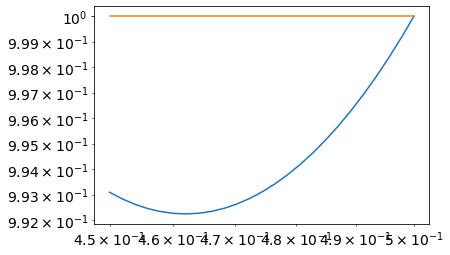

In [29]:
x_values = [0.5, 0.45]
y_value = 1
y_factor = 2**0.01
circle_x, circle_y = horizontal_circle_segment_loglog(x_values, y_value, y_factor)
print(circle_x)
print(circle_y)
print(np.exp(np.log(2)))
plt.loglog(circle_x, circle_y)
plt.loglog(x_values, [y_value]*2)

In [30]:
# Transposition of roles of x and y in plot above

def plot_all_submissions_flipped(y_key, x_key, y_label=None, x_label=None, x_transform=None, x_legend_label=None,
                                 secondary_x_keys=None, secondary_x_axis_label=None, secondary_x_legend_labels=None, secondary_x_transforms=None, secondary_x_markers=None, primary_to_secondary_x_transform=None, secondary_to_primary_x_transform=None, 
                                 secondary_y_key=None, secondary_y_label=None, secondary_y_legend_label=None, secondary_y_marker=None, primary_to_secondary_y_transform=None, secondary_to_primary_y_transform=None, 
                                 title=None, sharey=False, axis_scale='semilogx', filter_submissions=lambda s: True, color_label=None, show_symbolic_legend=True, ax=None):
    
    if type(y_key) is str:
        assert not y_key.startswith('run_')
    if type(secondary_y_key) is str:
        assert not secondary_y_key.startswith('run_')
    if type(x_key) is str:
        assert x_key.startswith('run_')
    if secondary_x_keys is not None:
        for secondary_x_key in secondary_x_keys:
            if type(secondary_x_key) is str:
                assert secondary_x_key.startswith('run_')

#     fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=sharey, #sharex=True, 
#                                    figsize=(36, 12))
#     ax_clsd = ax0
#     ax_open = ax1

    fig = None
    if ax is None:
        fig, ax = plt.subplots(ncols=1,
                               figsize=(24, 12))
    ax_clsd = ax
    ax_open = ax
    
    submission_label_annotation_opts = dict(
                        xytext=( 0, -8),
                        textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                        ha='right', va='top', rotation=90, #rotation=49,            
#                         xytext=(-20, 20),
#                         textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
#                         ha='right', va='center', rotation=60,
                        alpha=1., fontsize=12)
        
    colors = create_submission_colors(color_label=color_label, filter_submissions=filter_submissions)    

    if secondary_x_keys is not None:
        secondary_ax_clsd = ax_clsd.secondary_xaxis('top', functions=(primary_to_secondary_x_transform, secondary_to_primary_x_transform)) # primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_ax_open = ax_open.secondary_xaxis('top', functions=(primary_to_secondary_x_transform, secondary_to_primary_x_transform))
        else:
            secondary_ax_open = secondary_ax_clsd

    if secondary_y_key is not None:
        secondary_y_ax_clsd = ax_clsd.secondary_yaxis('right', functions=(primary_to_secondary_y_transform, secondary_to_primary_y_transform)) # primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_y_ax_open = ax_open.secondary_yaxis('right', functions=(primary_to_secondary_y_transform, secondary_to_primary_y_transform))
        else:
            secondary_y_ax_open = secondary_y_ax_clsd

    x_values_min = dict(closed=float('inf'), open=float('inf')) 
    x_values_max = dict(closed=float('-inf'), open=float('-inf'))
    y_values_min = dict(closed=float('inf'), open=float('inf')) 
    y_values_max = dict(closed=float('-inf'), open=float('-inf'))
    
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
        
        if not filter_submissions(submission_stat):
            continue

        color = colors[k if color_label is None else color_label(submission_stat)]
            
        y_values = submission_stat[y_key] if type(y_key) is str else y_key(submission_stat)
        y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(y_values))
        y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(y_values))
        if secondary_y_key is not None:
            secondary_y_values = submission_stat[secondary_y_key] if type(secondary_y_key) is str else secondary_y_key(submission_stat)
            secondary_y_values = secondary_to_primary_y_transform(secondary_y_values)
            y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(secondary_y_values))
            y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(secondary_y_values))

        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        x_values = np.array([run[x_key] if type(x_key) is str else x_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        if secondary_x_keys is not None:
            secondary_x_keys_not_none = []
            secondary_x_values = []
            for secondary_x_key in secondary_x_keys:
                secondary_x_values.append( np.array([run[secondary_x_key] if type(secondary_x_key) is str else secondary_x_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs]) )
                secondary_x_keys_not_none.append(None not in secondary_x_values[-1])
                if secondary_x_keys_not_none[-1]:
                    secondary_x_values[-1] = np.array([secondary_to_primary_x_transform(val) for val in secondary_x_values[-1]])
        
        if x_transform is not None:
            x_values = np.array([x_transform(val) for val in x_values])
#         print(x_values, flush=True)
        x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(x_values))
        x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(x_values))

        if secondary_x_keys is not None:
            for i in np.nonzero(secondary_x_keys_not_none)[0]: #for i,_ in enumerate(secondary_x_keys):
                if secondary_x_transforms[i] is not None:
                    secondary_x_values[i] = np.array([secondary_x_transforms[i](val) for val in secondary_x_values[i]])
                x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(secondary_x_values[i]))
                x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(secondary_x_values[i]))
        

        if submission_stat['division'] == 'closed':                
            x_values_unique = np.unique(x_values)
            x_values_frequency = np.array([np.sum(e == np.array(x_values)) for e in x_values_unique])
            ax_clsd.scatter(x_values_unique,
                        [y_values]*len(x_values_unique),
                        s=5*x_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_clsd.annotate(submission_stat['submission_short_label'],
                        xy=(np.mean(x_values), y_values),
                        color=color,
                        **submission_label_annotation_opts)
            if secondary_y_key is not None:                
                ax_clsd.plot([np.mean(x_values)]*2, 
                        [secondary_y_values, y_values], # requires secondary_x to primary x scale conversion if non-identity
                         '--',
                         color=color,
                         alpha=0.3)
                ax_clsd.scatter([np.mean(x_values)],
                         [secondary_y_values], # requires secondary_x to primary x scale conversion if non-identity
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_y_marker)                                           
            if secondary_x_keys is not None:
                for i in np.nonzero(secondary_x_keys_not_none)[0]: #for i,_ in enumerate(secondary_x_keys):
                    y_factor = 2**0.1
#                     ax_clsd.scatter(secondary_x_values[i],
#                                 [y_values/y_factor]*len(secondary_x_values[i]),
#                                 s=10,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_x_markers[i].lower())                    
#                     ax_clsd.scatter([np.mean(secondary_x_values[i])],
#                                 [y_values/y_factor],
#                                 s=20,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_x_markers[i])
                    ax_clsd.errorbar([np.mean(secondary_x_values[i])],
                                [y_values/y_factor],
                                xerr=[np.std(secondary_x_values[i])],
                                fmt=secondary_x_markers[i], #markersize=3,
                                color=color,
                                alpha=1.)
                    circle_x, circle_y = horizontal_circle_segment_loglog([np.mean(x_values), np.mean(secondary_x_values[i])], y_values, y_factor=y_factor)
                    ax_clsd.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=.3)
            if len(x_values_unique) != 1:
                epochs, probs = kde_estimate(x_values)
                ax_clsd.plot(   epochs,
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.5)
                ax_clsd.fill_between(
                            epochs,
                            [float(y_values)]*len(probs),
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.1)
        elif submission_stat['division'] == 'open':
            x_values_unique = np.unique(x_values)
            x_values_frequency = np.array([np.sum(e == np.array(x_values)) for e in x_values_unique])
            ax_open.scatter(x_values_unique,
                        [y_values]*len(x_values_unique),
                        s=5*x_values_frequency,
                        color=color,
                        label=r'$\bigstar$' + submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_open.annotate(r'$\bigstar$' + submission_stat['submission_short_label'],
#                         fontstyle='italic',
                        xy=(np.mean(x_values), y_values),
                        color=color,
                        **submission_label_annotation_opts)
            if secondary_y_key is not None:
                ax_open.plot([np.mean(x_values)]*2, 
                        [secondary_y_values, y_values], # requires secondary_x to primary x scale conversion if non-identity
                         '--',
                         color=color,
                         alpha=0.3)
                ax_open.scatter([np.mean(x_values)],
                         [secondary_y_values], # requires secondary_x to primary x scale conversion if non-identity
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_y_marker)                                           
            if secondary_x_keys is not None:
                for i in np.nonzero(secondary_x_keys_not_none)[0]: #for i,_ in enumerate(secondary_x_keys):
                    y_factor = 2**0.1
#                     ax_open.scatter(secondary_x_values[i],
#                                 [y_values/y_factor]*len(secondary_x_values[i]),
#                                 s=10,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_x_markers[i].lower())                    
#                     ax_open.scatter([np.mean(secondary_x_values[i])],
#                                 [y_values/y_factor],
#                                 s=20,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_x_markers[i])
                    ax_open.errorbar([np.mean(secondary_x_values[i])],
                                [y_values/y_factor],
                                xerr=[np.std(secondary_x_values[i])],
                                fmt=secondary_x_markers[i], #markersize=3,
                                color=color,
                                alpha=1.)
                    circle_x, circle_y = horizontal_circle_segment_loglog([np.mean(x_values), np.mean(secondary_x_values[i])], y_values, y_factor=y_factor)
                    ax_open.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=0.3)
            if len(x_values_unique) != 1:
                epochs, probs = kde_estimate(x_values)
                ax_open.plot(   epochs,
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.5)
                ax_open.fill_between(
                            epochs,
                            [float(y_values)]*len(probs),
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.1)
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")
    
#     ax_clsd.legend(bbox_to_anchor=(-.65, 1), loc='upper left', frameon=False, fontsize='small')
    ax_clsd.legend(bbox_to_anchor=( 1.1, 1), loc='upper left', frameon=False, fontsize='small')
    if ax_open != ax_clsd:
        ax_open.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')

    if show_symbolic_legend:
        symbolic_legend_labels = []
        ax_clsd_twin = ax_clsd.twinx()
        ax_clsd_twin.scatter([], [], label=x_legend_label, color='black')
        symbolic_legend_labels.append(x_legend_label)
        ax_clsd_twin.plot([], [], secondary_y_marker, label=secondary_y_legend_label, color='black')
        symbolic_legend_labels.append(secondary_y_legend_label)
        for i,_ in enumerate(secondary_x_keys):
            ax_clsd_twin.plot([], [], secondary_x_markers[i], label=secondary_x_legend_labels[i], color='black')
            symbolic_legend_labels.append(secondary_x_legend_labels[i])
        ax_clsd_twin.get_yaxis().set_visible(False)

        legend_handles, legend_labels = ax_clsd_twin.get_legend_handles_labels()
        legend_labels, legend_handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: symbolic_legend_labels.index(t[0])))
#         ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=(-.65, 0), loc='lower left', frameon=False, fontsize='small')
        ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=( 1.65, 0), loc='lower right', frameon=False, fontsize='small')
    
    ax_clsd.grid(True, which='major', alpha=0.3)
    ax_open.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax_clsd.plot()
        ax_open.plot()
    elif axis_scale == 'semilogx':
        ax_clsd.semilogx()
        ax_open.semilogx()
    elif axis_scale == 'loglog':
        ax_clsd.loglog()
        ax_open.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')
        
    
    plot_level_lines(ax=ax_clsd, 
                    x_range=(min(x_values_min['closed'],x_values_min['open']), max(x_values_max['closed'],x_values_max['open'])), 
                    y_range=(min(y_values_min['closed'],y_values_min['open']), max(y_values_max['closed'],y_values_max['open'])), 
                    level_func='x/y', 
                    level_label=(r'$\dfrac{compute\; throughput}{\#\; accelerators}$', r'$[samples/s]$'),
                    level_transform=(primary_to_secondary_x_transform, secondary_to_primary_x_transform))
                                         
#     print(min(y_values_min['closed'],y_values_min['open']))
#     print(max(y_values_max['closed'],y_values_max['open']))
    
#     print(min(x_values_min['closed'],x_values_min['open']))
#     print(max(x_values_max['closed'],x_values_max['open']), flush=True)
        
    if ax_clsd != ax_open:
        if math.isfinite(y_values_min['closed']) and math.isfinite(y_values_max['closed']):
            ax_clsd.set_ylim(bottom=y_values_min['closed']//2 if axis_scale != 'linear' else 0., top=y_values_max['closed']*2)
        if math.isfinite(y_values_min['open']) and math.isfinite(y_values_max['open']):
            ax_open.set_ylim(bottom=y_values_min['open']//2 if axis_scale != 'linear' else 0.,   top=y_values_max['open']*2)
    else:
        if math.isfinite(y_values_min['closed']) and math.isfinite(y_values_max['closed']):
            ax_clsd.set_ylim(bottom=min(y_values_min['closed']//2, y_values_min['open']//2) if axis_scale != 'linear' else 0., top=max(y_values_max['closed']*2, y_values_max['open']*2))
        


    ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
    ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

    #     plt.FuncFormatter(lambda t: "{}".format(t))
    ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())

    if secondary_x_keys is not None:
        secondary_ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
        secondary_ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

        #     plt.FuncFormatter(lambda t: "{}".format(t))
        secondary_ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        secondary_ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())
        secondary_ax_clsd.set_xlabel(secondary_x_axis_label if secondary_x_axis_label is not None else secondary_x_keys[0])
        secondary_ax_open.set_xlabel(secondary_x_axis_label if secondary_x_axis_label is not None else secondary_x_keys[0])

    if secondary_y_key is not None:
        secondary_y_ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
        secondary_y_ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

        #     plt.FuncFormatter(lambda t: "{}".format(t))
        secondary_y_ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        secondary_y_ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())
        secondary_y_ax_clsd.set_ylabel(secondary_y_label if secondary_y_label is not None else secondary_y_key)
        secondary_y_ax_open.set_ylabel(secondary_y_label if secondary_y_label is not None else secondary_y_key)
    
    ax_clsd.set_ylabel(y_label if y_label is not None else y_key)
    ax_open.set_ylabel(y_label if y_label is not None else y_key)
    ax_clsd.set_xlabel(x_label)
    ax_open.set_xlabel(x_label)

    if fig is not None:
        fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{y_label} vs. {x_label}'))
        fig.tight_layout()

In [31]:
#%matplotlib notebook

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def coord_transform(values, transform):
    if transform is None:
        return values
    else:
        return transform(values) if not hasattr(values,'__len__') else np.array([transform(val) for val in values])

def plot_all_submissions_3d(x_key, y_key, z_key, 
                            x_label=None, x_transform=None, 
                            y_label=None, y_transform=None, 
                            z_label=None, z_transform=None, 
                            title=None, sharez=False, 
                            axis_scale='semilogx', 
                            filter_submissions=lambda s: True, 
                            color_label=None):
    
    for key in [x_key, y_key]:
        if type(key) is str:
            assert not key.startswith('run_')
    if type(z_key) is str:
        assert z_key.startswith('run_')

    fig, (ax0, ax1) = plt.subplots(ncols=2, #sharez=sharez, #sharex=True, 
                                   figsize=(27, 9), subplot_kw={'projection':'3d'})

    cmap = plt.cm.get_cmap('prism')
    colors = cmap(np.arange(0,cmap.N))
    if color_label is None:
        colors = colors[::len(colors)//len(submissions_stats),:]*0.7
    else:
        color_label_range = np.unique([color_label(submission_stat) for submission_stat in submissions_stats.values() if filter_submissions(submission_stat)])
        colors = colors[::len(colors)//len(color_label_range),:]*0.7
#         np.random.shuffle(colors)
        colors = dict(zip(color_label_range, colors))
    
    # Plot all submissions
    ax0_text = []
    ax1_text = []
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
        
        if not filter_submissions(submission_stat):
            continue

        color = colors[i if color_label is None else color_label(submission_stat)]
            
        x_values = submission_stat[x_key] if type(x_key) is str else x_key(submission_stat)
        y_values = submission_stat[y_key] if type(y_key) is str else y_key(submission_stat)

        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        z_values = np.array([run[z_key] if type(z_key) is str else z_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        z_values = coord_transform(z_values, z_transform)
        
#         print(z_values, flush=True)

        if submission_stat['division'] == 'closed':                
            z_values_unique = np.unique(z_values)
            z_values_frequency = np.array([np.sum(e == np.array(z_values)) for e in z_values_unique])
            ax0.scatter(coord_transform([x_values]*len(z_values_unique), x_transform),
                        coord_transform([y_values]*len(z_values_unique), y_transform),
                        z_values_unique,
                        s=10*z_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)

            ax0_text.append(dict(x=coord_transform(x_values, x_transform), 
                     y=coord_transform(y_values, y_transform), 
                     z=np.mean(z_values),
                     s=submission_stat['submission_short_label'], #textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color }, ha='right', va='center',  # rotation=90,
                     color=color,
                     fontsize='small',
                     alpha=1.))
            
            if len(z_values_unique) != 1:
                epochs, probs = kde_estimate(z_values)
                ax0.plot(   coord_transform(float(x_values)*2**(np.std(z_values)*probs), x_transform),
                            coord_transform(float(y_values)*2**(np.std(z_values)*probs), y_transform),
                            epochs,
                            color=color,
                            alpha=0.5)
                
                verts = list(zip(coord_transform([float(x_values)]*len(probs), x_transform),
                                 coord_transform([float(y_values)]*len(probs), y_transform),
                                 epochs))
                verts.reverse()
                verts += list(zip(coord_transform(float(x_values)*2**(np.std(z_values)*probs), x_transform),
                                  coord_transform(float(y_values)*2**(np.std(z_values)*probs), y_transform), 
                                  epochs))
                ax0.add_collection3d(Poly3DCollection([verts], color=color, alpha=0.1))
                
        elif submission_stat['division'] == 'open':
            z_values_unique = np.unique(z_values)
            z_values_frequency = np.array([np.sum(e == np.array(z_values)) for e in z_values_unique])
            ax1.scatter(coord_transform([x_values]*len(z_values_unique), x_transform),
                        coord_transform([y_values]*len(z_values_unique), y_transform),
                        z_values_unique,
                        s=10*z_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            
            ax1_text.append(dict(x=coord_transform(x_values, x_transform), 
                     y=coord_transform(y_values, y_transform), 
                     z=np.mean(z_values),
                     s=submission_stat['submission_short_label'], #textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color }, ha='right', va='center',  # rotation=90,
                     color=color,
                     fontsize='small',
                     alpha=1.))
            
            if len(z_values_unique) != 1:
                epochs, probs = kde_estimate(z_values)
                ax1.plot(   coord_transform(float(x_values)*2**(np.std(z_values)*probs), x_transform),
                            coord_transform(float(y_values)*2**(np.std(z_values)*probs), y_transform),
                            epochs,
                            color=color,
                            alpha=0.5)
                
                verts = list(zip(coord_transform([float(x_values)]*len(probs), x_transform),
                                 coord_transform([float(y_values)]*len(probs), y_transform),
                                 epochs))
                verts.reverse()
                verts += list(zip(coord_transform(float(x_values)*2**(np.std(z_values)*probs), x_transform),
                                  coord_transform(float(y_values)*2**(np.std(z_values)*probs), y_transform), 
                                  epochs))
                ax1.add_collection3d(Poly3DCollection([verts], color=color, alpha=0.1))
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")

    ax0.legend(bbox_to_anchor=(-.45, 1), loc='upper left', frameon=False, fontsize='medium')
    ax1.legend(bbox_to_anchor=(1.45, 1), loc='upper right', frameon=False, fontsize='medium')

    ax0.grid(True, which='major', alpha=0.3)
    ax1.grid(True, which='major', alpha=0.3)

#     # setting axis scale other than linear non-functional in 3d, must be done with coord_transforms
#     if axis_scale == 'linear':
#         pass    
#         ax0.set_xscale('linear')
#         ax0.set_yscale('linear')
#         ax0.set_zscale('linear')
#         ax1.set_xscale('linear')
#         ax1.set_yscale('linear')
#         ax1.set_zscale('linear')
#     elif axis_scale == 'semilogx':
#         ax0.set_xscale('log')
#         ax0.set_yscale('log')
#         ax0.set_zscale('linear')
#         ax1.set_xscale('log')
#         ax1.set_yscale('log')
#         ax1.set_zscale('linear')
#     elif axis_scale == 'loglog':
#         ax0.set_xscale('log')
#         ax0.set_yscale('log')
#         ax0.set_zscale('log')
#         ax1.set_xscale('log')
#         ax1.set_yscale('log')
#         ax1.set_zscale('log')
#     else:
#         raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')
    
    x_range = dict()
    y_range = dict()

    for division in ['closed', 'open']:
        x_range[division] = [submission_stat[x_key] if type(x_key) is str else x_key(submission_stat) for submission_stat in submissions_stats.values() if submission_stat['division'] == division and filter_submissions(submission_stat)]
        y_range[division] = [submission_stat[y_key] if type(y_key) is str else y_key(submission_stat) for submission_stat in submissions_stats.values() if submission_stat['division'] == division and filter_submissions(submission_stat)]

    if len(x_range['closed']) > 0:
        ax0.set_xlim(left=coord_transform(np.min(x_range['closed'])/2. if axis_scale != 'linear' else 0., x_transform), right=coord_transform(np.max(x_range['closed'])*2., x_transform))
        ax0.set_ylim(bottom=coord_transform(np.min(y_range['closed'])/2. if axis_scale != 'linear' else 0., y_transform), top=coord_transform(np.max(y_range['closed'])*2., y_transform))
        for text in ax0_text:
            text['x'] -= 0.09*(ax0.get_xlim()[1]-ax0.get_xlim()[0])
            text['y'] -= 0.09*(ax0.get_ylim()[1]-ax0.get_ylim()[0])
            text['z'] *= 1.02
            ax0.text(**text)
    if len(x_range['open']) > 0:
        ax1.set_xlim(left=coord_transform(np.min(x_range['open'])/2. if axis_scale != 'linear' else 0., x_transform),   right=coord_transform(np.max(x_range['open'])*2., x_transform))
        ax1.set_ylim(bottom=coord_transform(np.min(y_range['open'])/2. if axis_scale != 'linear' else 0., y_transform),   top=coord_transform(np.max(y_range['open'])*2., y_transform))
        for text in ax1_text:
            text['x'] -= 0.08*(ax1.get_xlim()[1]-ax1.get_xlim()[0])
            text['y'] -= 0.08*(ax1.get_ylim()[1]-ax1.get_ylim()[0])
            text['z'] *= 1.02
            ax1.text(**text)

    ax0.xaxis.set_major_locator(plt.AutoLocator())
    ax1.xaxis.set_major_locator(plt.AutoLocator())
    ax0.yaxis.set_major_locator(plt.AutoLocator())
    ax1.yaxis.set_major_locator(plt.AutoLocator())

    #     plt.FuncFormatter(lambda t: "{}".format(t))
    ax0.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax1.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax0.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax1.yaxis.set_major_formatter(plt.ScalarFormatter())

    ax0.set_xlabel(x_label if x_label is not None else x_key)
    ax1.set_xlabel(x_label if x_label is not None else x_key)
    ax0.set_ylabel(y_label if y_label is not None else y_key)
    ax1.set_ylabel(y_label if y_label is not None else y_key)
    ax0.set_zlabel(z_label)
    ax1.set_zlabel(z_label)

    fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'({x_label}, {y_label}) vs. {z_label}'))
    fig.tight_layout()

### Label definitions/helpers

In [32]:
if benchmark.round == 'hpc_results_v0.7':
    accelerator_short_names = [
            'A64FX',
            'V100',
            'P100',
            'Quadro RTX 5000',
            'Intel Xeon Phi']
elif benchmark.round == 'training_results_v0.7':
    accelerator_short_names = [
        'Intel(R) Xeon(R)', #' Platinum 8380H',
        'TPU v3',
        'TPU',
#         'A100-SXM4-40GB',
        'A100',
#         'V100-SXM2-32GB',
#         'V100-SXM3-32GB',
#         'V100-SXM2-16GB',
        'V100',
        'Ascend910']
    
def accelerator_name(system):
    return system['accelerator_model_name'] if int(system['accelerators_per_node']) > 0 else system['host_processor_model_name'] 

def accelerator_short_label(submission_stat):
    name = accelerator_name(submission_stat['system'])
    for short_name in accelerator_short_names:
        if short_name in name:
            return short_name

def accelerator_number(system):
    number_of_nodes = int(system['number_of_nodes'])
    accelerators_per_node = int(system['accelerators_per_node'] if int(system['accelerators_per_node']) > 0 else system['host_processors_per_node'])
    return number_of_nodes*accelerators_per_node

if benchmark.round == 'hpc_results_v0.7':
    # Estimating peak performance (TBC: check numbers - Tensor Core performance too high as a reference)
    tflops = {
        'A64FX': 6.8,
        'V100': 112.,
        'P100': 9.3,
        'Quadro RTX 5000': 89.2,
        'Intel Xeon Phi': 3.,
    }

    def get_pflops(system):
        for tfl_key, tfl_val in tflops.items():
            if tfl_key in accelerator_name(system):
                return tfl_val*accelerator_number(system)/1000.

    display({ f'{accelerator_number(v["system"])}x{accelerator_name(v["system"])}': 
                 get_pflops(v['system']) for v in submissions_stats.values() })

{'2048xNVIDIA Tesla V100': 229.376,
 '16384xFUJITSU Processor A64FX': 111.4112,
 '8192xFUJITSU Processor A64FX': 55.7056,
 '512xNVIDIA Tesla V100': 57.344,
 '512xFUJITSU Processor A64FX': 3.4816,
 '256xNVIDIA P100-PCIE-16GB': 2.3808000000000002,
 '128xNVIDIA P100-PCIE-16GB': 1.1904000000000001,
 '64xNVIDIA Tesla V100': 7.168,
 '512xIntel Xeon Phi Processor 7250': 1.536,
 '1024xIntel Xeon Phi Processor 7250': 3.072,
 '64xNVIDIA V100': 7.168,
 '64xNVIDIA Quadro RTX 5000': 5.7088}

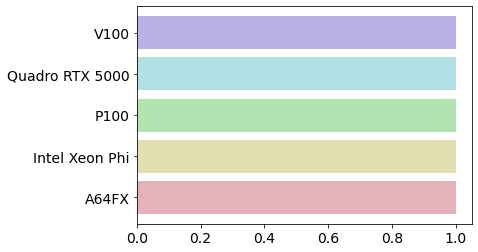

In [33]:
show_submission_colors(color_label=accelerator_short_label, alpha=0.3)

### 3D visualization (interactive data exploration in Jupyter notebook)

In [34]:
%%script echo Remove this line for visualization in Jupyter notebook (not working in Jupyter lab)
%matplotlib notebook

# Some choices for x-/y-/z-axes
x_label = 'log(batch size)'
x_key = 'global_batch_size'
x_transform = np.log2

# y_label = 'log(# accelerators)'
# y_key = lambda submission_stat: accelerator_number(submission_stat['system'])
# y_transform = np.log2

y_label = 'log(batch size/# accelerators)'
y_key = lambda submission_stat: float(submission_stat['global_batch_size'])/accelerator_number(submission_stat['system'])
y_transform = np.log2

# z_label = '# epochs to solution'
# z_key = 'run_stop_epoch'
# z_transform = None

# z_label = 'epoch throughput [1/min]'
# z_key = 'run_epoch_throughput'
# z_transform = lambda t: t/60.

z_label = 'epoch throughput per accelerator [1/min]'
z_key = lambda submission_stat: submission_stat['run']['run_stop_epoch']/(submission_stat['run']['run_time']*accelerator_number(submission_stat['system']))
z_transform = lambda t: t*60.


plot_all_submissions_3d(x_key=x_key, x_label=x_label, x_transform=x_transform, 
                        y_key=y_key, y_label=y_label, y_transform=y_transform, 
                        z_key=z_key, z_label=z_label, z_transform=z_transform, 
                        sharez=True, axis_scale='semilogx', color_label=accelerator_short_label)

Remove this line for visualization in Jupyter notebook (not working in Jupyter lab)


### 2d visualizations

In [35]:
# Plot parameters

# x-axis

x_label = 'batch size'
x_key = 'global_batch_size'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

# y-axis

y_label = '# epochs to solution'
y_key = 'run_stop_epoch'
y_transform = None

y_label = 'time to solution [min]'
y_key = 'run_time'
y_transform = lambda t: t/60.
    
y_label = 'epoch throughput [1/min]'
y_key = 'run_epoch_throughput'
y_transform = lambda t: t/60.
    
def get_accelerator_hours(run_system_stats):
    return run_system_stats['run']['run_time']/3600*accelerator_number(run_system_stats['system'])

y_label = 'accelerator hours'
y_key = get_accelerator_hours
y_transform = None
    
def get_pflopsdays(run_system_stats):
    return run_system_stats['run']['run_time']/3600./24.*get_pflops(run_system_stats['system'])

y_label = 'PF/s-days'
y_key = get_pflopsdays
y_transform = None

In [36]:
# Checking for correlations of individual hyperparameters on number of epochs to converge is possible (not very helpful when everyone roughly uses the same - hence "if False")

if benchmark.name == 'cosmoflow' and False:
    x_key = lambda run_system_stats: float(run_system_stats['opt_opts']['opt_learning_rate_decay_boundary_epochs'][1])
    x_label = 'opt_learning_rate_decay_boundary_epochs[1]'
    filter_submissions = lambda submission_stat: submission_stat['division'] == 'closed'

    y_label = '# epochs to solution'
    y_key = 'run_stop_epoch'
    y_transform = None

    plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, filter_submissions=filter_submissions)

In [37]:
if benchmark.round == 'hpc_results_v0.7':
    batch_size_to_accelerator_ratio = 1.
elif benchmark.name == 'resnet':
    batch_size_to_accelerator_ratio = np.min([s['global_batch_size']/accelerator_number(s['system']) for s in submissions_stats.values()])
batch_size_to_accelerator_ratio

1.0

## Time to solution

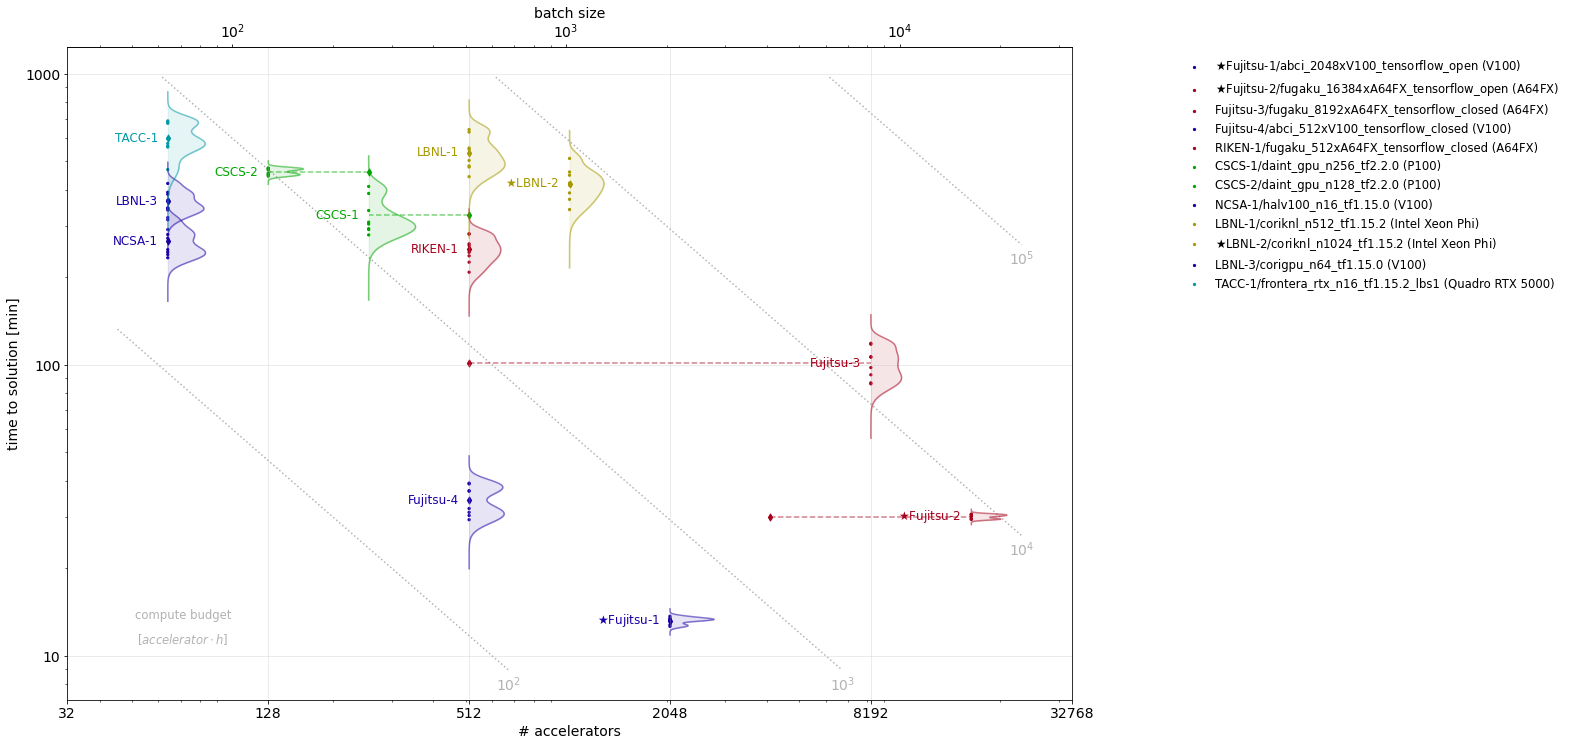

In [38]:
fig, ax = plt.subplots(ncols=1,
                       figsize=(18, 12))

# x_label = 'batch size'
# x_key = 'global_batch_size'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

secondary_x_label = 'batch size'
secondary_x_key = 'global_batch_size'
secondary_x_marker = 'd'

primary_to_secondary_x_transform = lambda a: a*batch_size_to_accelerator_ratio
secondary_to_primary_x_transform = lambda b: b/batch_size_to_accelerator_ratio

y_label = 'time to solution [min]'
y_key = 'run_time'
y_transform = lambda t: t/60.
    
plot_all_submissions(x_key=x_key, x_label=x_label, 
                     secondary_x_key=secondary_x_key, secondary_x_label=secondary_x_label, secondary_x_marker=secondary_x_marker,
                     y_key=y_key, y_label=y_label, y_transform=y_transform, 
                     primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform,
                     sharey=True, axis_scale='loglog', color_label=accelerator_short_label,
                     level_func='x*y', level_label=(r'compute budget', r'$[accelerator \cdot h]$'), level_transform=(lambda l, s: l/60, lambda l, s: l*60), ax=ax)

ax.yaxis.set_major_locator(plt.LogLocator(base=10.))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))


## Submission parameter choices (system- & hyper-parameters): granularity of data parallelism, etc.

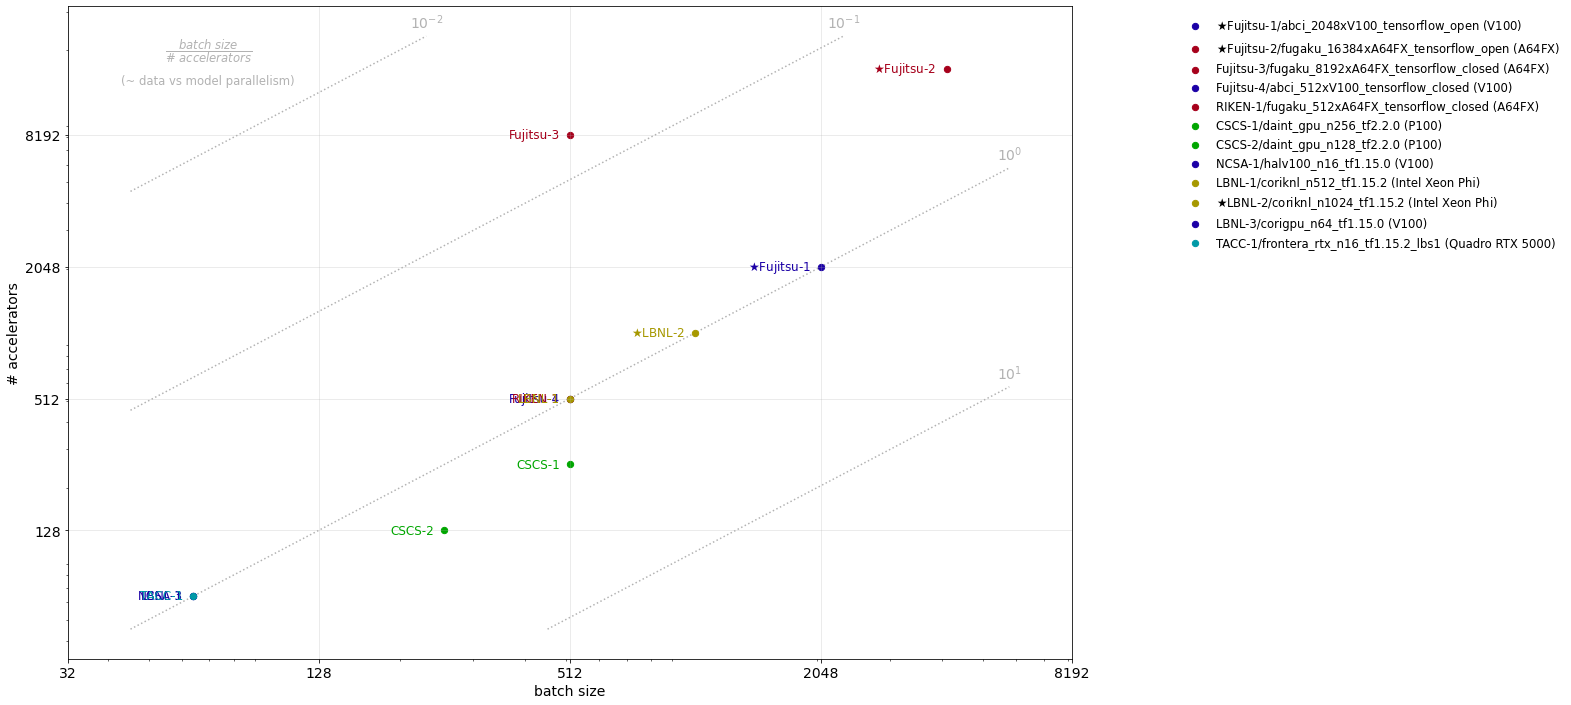

In [39]:
fig, ax = plt.subplots(ncols=1,
                       figsize=(18, 12))
x_label = 'batch size'
x_key = 'global_batch_size'

y_label = '# accelerators'
y_key = lambda submission_stat: accelerator_number(submission_stat['system'])
y_transform=None

# y_label = 'time to solution [min]'
# y_key = 'run_time'
# y_transform = lambda t: t/60.
    
plot_all_submissions(x_key=x_key, x_label=x_label, 
                     y_key=y_key, y_label=y_label, y_transform=y_transform, 
                     level_func='x/y', level_label=(r'$\dfrac{batch\ size}{\#\ accelerators}$', r'(~ data vs model parallelism)'),
                     sharey=True, axis_scale='loglog', color_label=accelerator_short_label,
                     format_y_axis_as_x_axis=True, ax=ax)

## # epochs (train steps) to solution as a function of batch size (& possibly hyperparameters) - cf. train steps to solution (data parallel scaling limit)

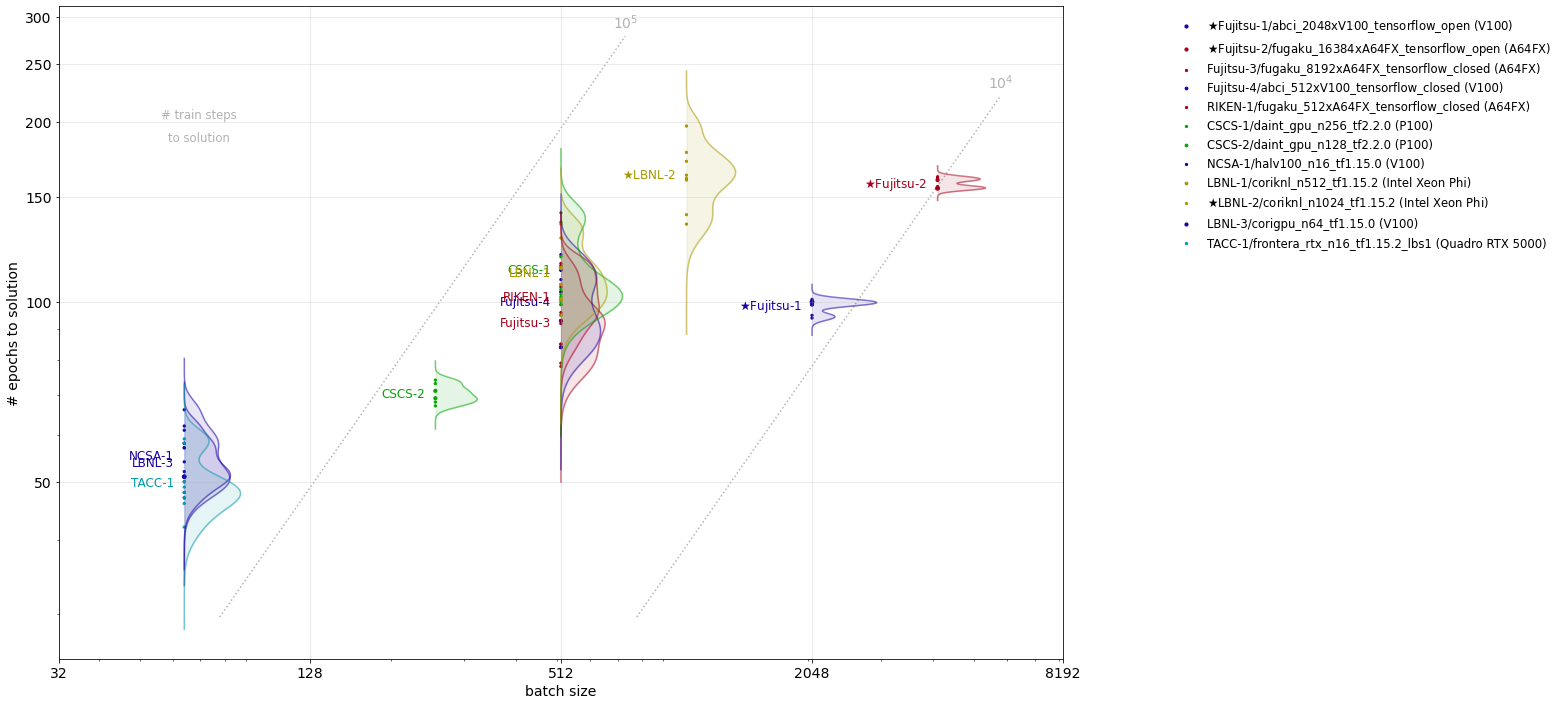

In [40]:
fig, ax = plt.subplots(ncols=1,
                       figsize=(18, 12))

x_label = 'batch size'
x_key = 'global_batch_size'

# x_label = '# accelerators'
# x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

y_label = '# epochs to solution'
y_key = 'run_stop_epoch'
y_transform = None

plot_all_submissions(x_key=x_key, x_label=x_label, 
                     y_key=y_key, y_label=y_label, y_transform=y_transform, 
                     level_func='y/x', level_label=(r'# train steps', r'to solution'), 
                     level_transform=(lambda l, s: l*s['train_samples'], lambda l, s: l/s['train_samples']),
                     sharey=True, axis_scale='loglog', color_label=accelerator_short_label, ax=ax)

ax.yaxis.set_major_locator(plt.AutoLocator())
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(plt.LogLocator(base=2.))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))


## compute throughput (train/evaluation/epochs/avg samples) as a function of # accelerators and batch size

In [41]:
def get_effective_epoch_samples(submissions_stats):
    submission_train_samples = np.unique([stat['train_samples'] for stat in submissions_stats.values()])
    if len(submission_train_samples) > 1:
        print("Warning: different number of training samples used in different submissions! Using median of {}".format(submission_train_samples))
    submission_train_samples = np.median(submission_train_samples)


    submission_eval_samples = np.unique([stat['eval_samples'] for stat in submissions_stats.values()])
    if len(submission_eval_samples) > 1:
        print("Warning: different number of evaluation samples used in different submissions! Using median of {}".format(submission_train_samples))
    submission_eval_samples = np.median(submission_eval_samples)

    mean_eff_epoch_samples = [] # handle DeepCAM separately
    submissions_runs_with_olympic_scoring = [(k, sorted(submission_stat['runs'], key=lambda run: run['run_time'])[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1]) 
                                             for k, submission_stat in submissions_stats.items()] # olympic scoring rules
    for k, runs in submissions_runs_with_olympic_scoring:
#         print(k)
#         print([runs[i]['run_epoch_samples'] for i in range(len(runs))])
#         print([len(runs[i]['run_epochs']) for i in range(len(runs))])
#         print([len(runs[i]['run_evals']) for i in range(len(runs))])
        submission_eff_epoch_samples = [runs[i]['run_eff_epoch_samples'] for i in range(len(runs))]
        if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow':
            assert np.unique(submission_eff_epoch_samples) == np.array([submission_train_samples + submission_eval_samples])
        else:
            mean_eff_epoch_samples.append(np.mean(submission_eff_epoch_samples))
    
    if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow':
        eff_epoch_samples = submission_train_samples + submission_eval_samples
    else:
        eff_epoch_samples = int(np.mean(mean_eff_epoch_samples))
    return eff_epoch_samples


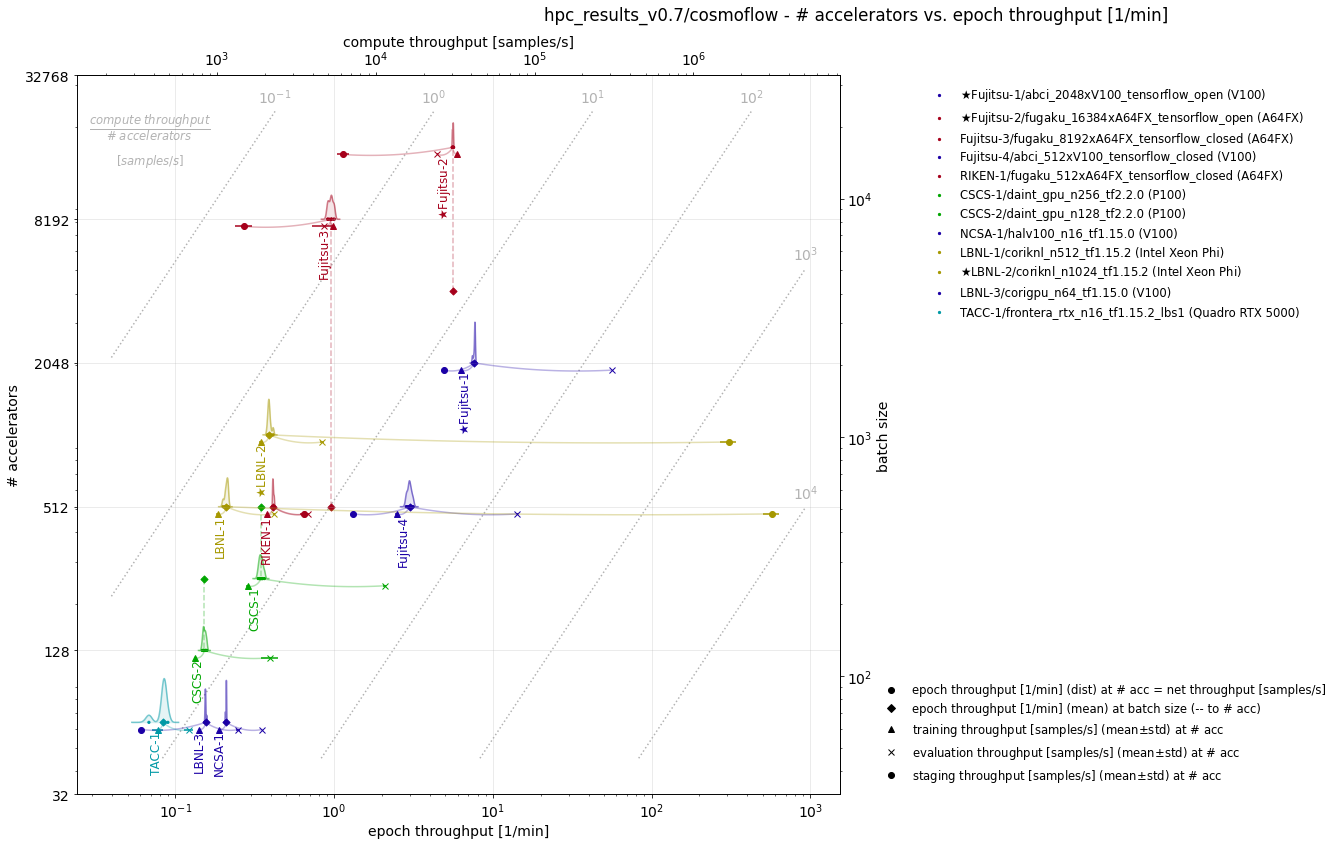

In [42]:
secondary_y_label = 'batch size'
secondary_y_legend_label = 'epoch throughput [1/min] (mean) at batch size (-- to # acc)'
secondary_y_key = 'global_batch_size'
secondary_y_marker = 'D'

y_label = '# accelerators'
y_key = lambda submission_stat: accelerator_number(submission_stat['system'])

primary_to_secondary_y_transform = lambda a: a*batch_size_to_accelerator_ratio
secondary_to_primary_y_transform = lambda b: b/batch_size_to_accelerator_ratio

# TODO: epoch time

x_label = 'epoch throughput [1/min]'
x_legend_label = 'epoch throughput [1/min] (dist) at # acc = net throughput [samples/s]' if benchmark.round != 'hpc_results_v0.7' or benchmark.name != 'deepcam' else 'epoch throughput [1/min] (dist) at # acc'
x_key = 'run_epoch_throughput'
x_transform = lambda t: t*60.
    

secondary_x_keys = []
secondary_x_legend_labels = []
secondary_x_transforms = []
secondary_x_markers = []

secondary_x_keys.append('run_train_throughput')
secondary_x_transforms.append(lambda t: t) #*60.
secondary_x_markers.append('^')
secondary_x_legend_labels.append(r'training throughput [samples/s] (mean$\pm$std) at # acc')

secondary_x_keys.append('run_eval_throughput')
secondary_x_transforms.append(lambda t: t) #*60.
secondary_x_markers.append('x')
secondary_x_legend_labels.append(r'evaluation throughput [samples/s] (mean$\pm$std) at # acc')

if benchmark.round == 'hpc_results_v0.7':
    secondary_x_keys.append('run_staging_throughput')
    secondary_x_transforms.append(lambda t: t) #*60.
    secondary_x_markers.append('o')
    secondary_x_legend_labels.append(r'staging throughput [samples/s] (mean$\pm$std) at # acc')

secondary_x_axis_label = 'compute throughput [samples/s]'

eff_epoch_samples = get_effective_epoch_samples(submissions_stats)
primary_to_secondary_x_transform = lambda et: et*float(eff_epoch_samples)/60. 
secondary_to_primary_x_transform = lambda st: st/float(eff_epoch_samples)*60.

# Epoch throughput w/o initial phase, i.e. staging overhead not shown (makes very minor difference, probably worth mentioning in text rather)

plot_all_submissions_flipped(x_key=x_key, x_label=x_label, x_transform=x_transform, x_legend_label=x_legend_label, 
                             secondary_x_keys=secondary_x_keys, secondary_x_axis_label=secondary_x_axis_label, secondary_x_legend_labels=secondary_x_legend_labels, secondary_x_transforms=secondary_x_transforms, secondary_x_markers=secondary_x_markers,
                             primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform,
                             y_key=y_key, y_label=y_label,
                             secondary_y_key=secondary_y_key, secondary_y_label=secondary_y_label, secondary_y_legend_label=secondary_y_legend_label, secondary_y_marker=secondary_y_marker, 
                             primary_to_secondary_y_transform=primary_to_secondary_y_transform, secondary_to_primary_y_transform=secondary_to_primary_y_transform, 
                             sharey=False, axis_scale='loglog', color_label=accelerator_short_label)


### ...with axes transposed

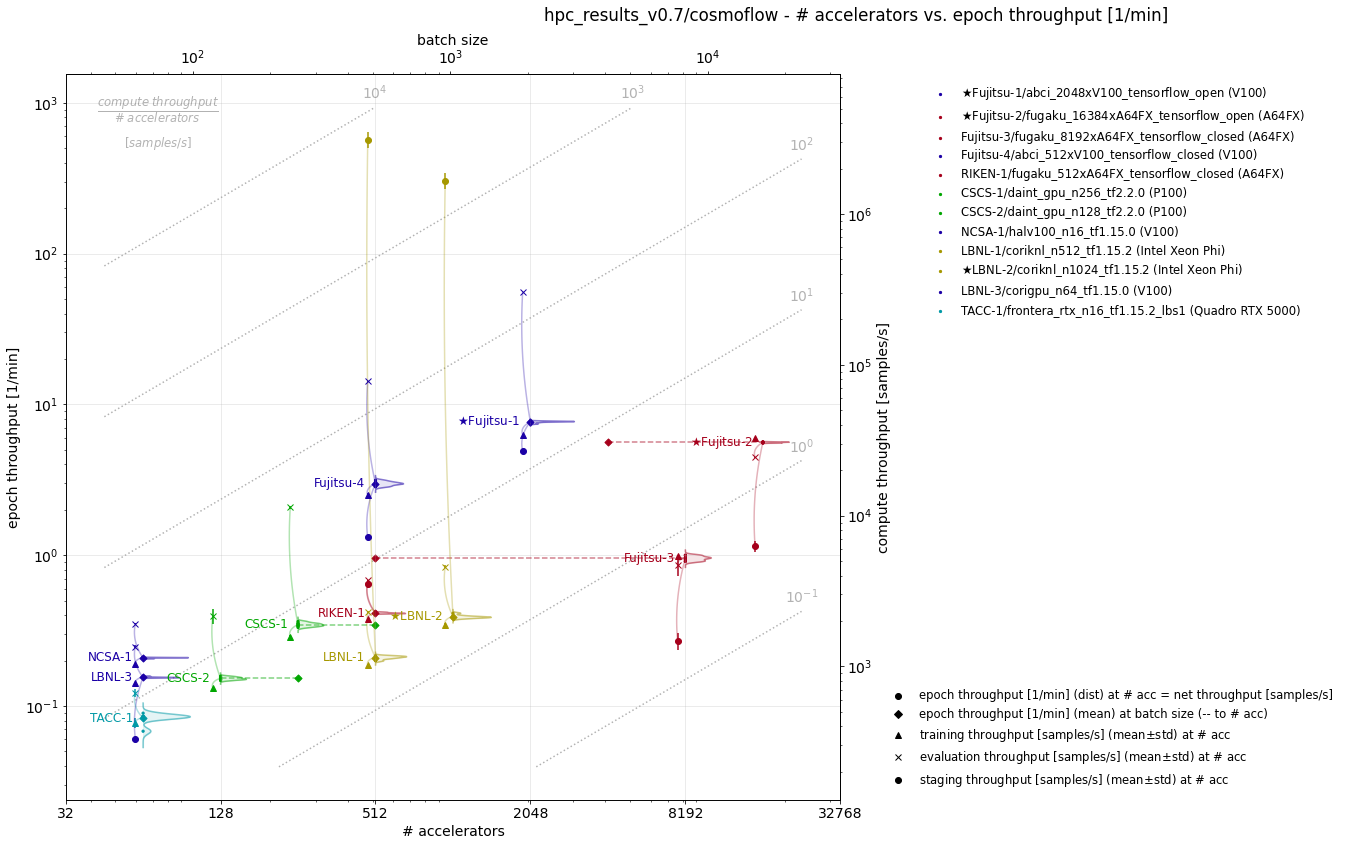

In [43]:
secondary_x_label = 'batch size'
secondary_x_legend_label = 'epoch throughput [1/min] (mean) at batch size (-- to # acc)'
secondary_x_key = 'global_batch_size'
secondary_x_marker = 'D'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

primary_to_secondary_x_transform = lambda a: a*batch_size_to_accelerator_ratio
secondary_to_primary_x_transform = lambda b: b/batch_size_to_accelerator_ratio

# TODO: epoch time

y_label = 'epoch throughput [1/min]'
y_legend_label = 'epoch throughput [1/min] (dist) at # acc = net throughput [samples/s]' if benchmark.round != 'hpc_results_v0.7' or benchmark.name != 'deepcam' else 'epoch throughput [1/min] (dist) at # acc'
y_key = 'run_epoch_throughput'
y_transform = lambda t: t*60.

secondary_y_keys = []
secondary_y_legend_labels = []
secondary_y_transforms = []
secondary_y_markers = []

secondary_y_keys.append('run_train_throughput')
secondary_y_transforms.append(lambda t: t) #*60.
secondary_y_markers.append('^')
secondary_y_legend_labels.append(r'training throughput [samples/s] (mean$\pm$std) at # acc')

secondary_y_keys.append('run_eval_throughput')
secondary_y_transforms.append(lambda t: t) #*60.
secondary_y_markers.append('x')
secondary_y_legend_labels.append(r'evaluation throughput [samples/s] (mean$\pm$std) at # acc')

if benchmark.round == 'hpc_results_v0.7':
    secondary_y_keys.append('run_staging_throughput')
    secondary_y_transforms.append(lambda t: t) #*60.
    secondary_y_markers.append('o')
    secondary_y_legend_labels.append(r'staging throughput [samples/s] (mean$\pm$std) at # acc')

secondary_y_axis_label = 'compute throughput [samples/s]'

eff_epoch_samples = get_effective_epoch_samples(submissions_stats)
primary_to_secondary_y_transform = lambda et: et*float(eff_epoch_samples)/60. 
secondary_to_primary_y_transform = lambda st: st/float(eff_epoch_samples)*60.

# Epoch throughput w/o initial phase, i.e. staging overhead not shown (makes very minor difference, probably worth mentioning in text rather)

level_func='y/x' 
level_label=(r'$\dfrac{compute\; throughput}{\#\; accelerators}$', r'$[samples/s]$')
level_transform=(primary_to_secondary_y_transform, secondary_to_primary_y_transform)

plot_all_submissions(y_key=y_key, y_label=y_label, y_transform=y_transform, y_legend_label=y_legend_label, 
                     secondary_y_keys=secondary_y_keys, secondary_y_axis_label=secondary_y_axis_label, secondary_y_legend_labels=secondary_y_legend_labels, secondary_y_transforms=secondary_y_transforms, secondary_y_markers=secondary_y_markers,
                     primary_to_secondary_y_transform=primary_to_secondary_y_transform, secondary_to_primary_y_transform=secondary_to_primary_y_transform,
                     x_key=x_key, x_label=x_label,
                     secondary_x_key=secondary_x_key, secondary_x_label=secondary_x_label, secondary_x_legend_label=secondary_x_legend_label, secondary_x_marker=secondary_x_marker, 
                     primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform, 
                     sharey=False, axis_scale='loglog', color_label=accelerator_short_label, show_symbolic_legend=True,
                     level_func=level_func, level_label=level_label, level_transform=level_transform)        


In [44]:
if benchmark.round == 'training_results_v0.7':
    plot_all_submissions(y_key=y_key, y_label=y_label, y_transform=y_transform, y_legend_label=y_legend_label, 
                         secondary_y_keys=secondary_y_keys, secondary_y_axis_label=secondary_y_axis_label, secondary_y_legend_labels=secondary_y_legend_labels, secondary_y_transforms=secondary_y_transforms, secondary_y_markers=secondary_y_markers,
                         primary_to_secondary_y_transform=primary_to_secondary_y_transform, secondary_to_primary_y_transform=secondary_to_primary_y_transform,
                         x_key=x_key, x_label=x_label,
                         secondary_x_key=secondary_x_key, secondary_x_label=secondary_x_label, secondary_x_legend_label=secondary_x_legend_label, secondary_x_marker=secondary_x_marker, 
                         primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform, 
                         sharey=False, axis_scale='loglog', color_label=accelerator_short_label, show_symbolic_legend=True,
                         level_func=level_func, level_label=level_label, level_transform=level_transform,
                         filter_submissions=lambda s: s['system']['submitter'] in ['Google', 'NVIDIA'])        


### compute throughput per accelerator as a function of # accelerators and batch size

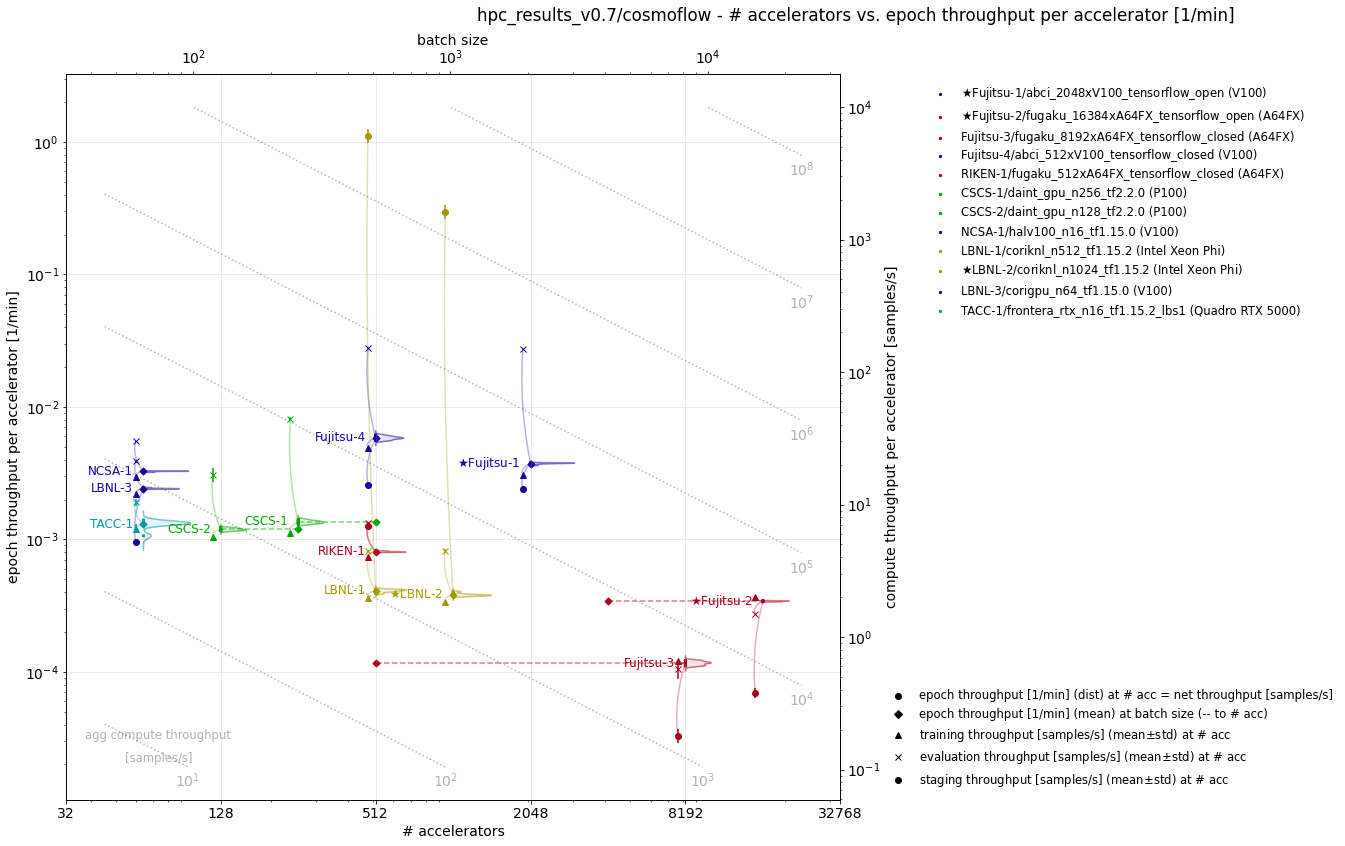

In [45]:
secondary_x_label = 'batch size'
secondary_x_legend_label = 'epoch throughput [1/min] (mean) at batch size (-- to # acc)'
secondary_x_key = 'global_batch_size'
secondary_x_marker = 'D'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

primary_to_secondary_x_transform = lambda a: a*batch_size_to_accelerator_ratio
secondary_to_primary_x_transform = lambda b: b/batch_size_to_accelerator_ratio

# TODO: epoch time

# y_label = 'epoch throughput [1/min]'
# y_legend_label = 'epoch throughput [1/min] (dist) at # acc = net throughput [samples/s]'
# y_key = 'run_epoch_throughput'
# y_transform = lambda t: t*60.

y_label = 'epoch throughput per accelerator [1/min]'
y_legend_label = 'epoch throughput [1/min] (dist) at # acc = net throughput [samples/s]' if benchmark.round != 'hpc_results_v0.7' or benchmark.name != 'deepcam' else 'epoch throughput [1/min] (dist) at # acc'
y_key = lambda submission_stat: submission_stat['run']['run_epoch_throughput']/(accelerator_number(submission_stat['system']))
y_transform = lambda t: t*60.

secondary_y_keys = []
secondary_y_legend_labels = []
secondary_y_transforms = []
secondary_y_markers = []

secondary_y_keys.append(lambda submission_stat: submission_stat['run']['run_train_throughput']/(accelerator_number(submission_stat['system'])))
secondary_y_transforms.append(lambda t: t) #*60.
secondary_y_markers.append('^')
secondary_y_legend_labels.append(r'training throughput [samples/s] (mean$\pm$std) at # acc')

secondary_y_keys.append(lambda submission_stat: submission_stat['run']['run_eval_throughput']/(accelerator_number(submission_stat['system'])) if submission_stat['run']['run_eval_throughput'] is not None else None)
secondary_y_transforms.append(lambda t: t) #*60.
secondary_y_markers.append('x')
secondary_y_legend_labels.append(r'evaluation throughput [samples/s] (mean$\pm$std) at # acc')

if benchmark.round == 'hpc_results_v0.7':
    secondary_y_keys.append(lambda submission_stat: submission_stat['run']['run_staging_throughput']/(accelerator_number(submission_stat['system'])) if submission_stat['run']['run_staging_throughput'] is not None else None)
    secondary_y_transforms.append(lambda t: t) #*60.
    secondary_y_markers.append('o')
    secondary_y_legend_labels.append(r'staging throughput [samples/s] (mean$\pm$std) at # acc')

secondary_y_axis_label = 'compute throughput per accelerator [samples/s]'

eff_epoch_samples = get_effective_epoch_samples(submissions_stats)
primary_to_secondary_y_transform = lambda et: et*float(eff_epoch_samples)/60. 
secondary_to_primary_y_transform = lambda st: st/float(eff_epoch_samples)*60.

# Epoch throughput w/o initial phase, i.e. staging overhead not shown (makes very minor difference, probably worth mentioning in text rather)

level_func='y*x' 
level_label=(r'agg compute throughput', r'[samples/s]')
level_transform=(primary_to_secondary_y_transform, secondary_to_primary_y_transform) # set to None for epoch throughput

plot_all_submissions(y_key=y_key, y_label=y_label, y_transform=y_transform, y_legend_label=y_legend_label, 
                     secondary_y_keys=secondary_y_keys, secondary_y_axis_label=secondary_y_axis_label, secondary_y_legend_labels=secondary_y_legend_labels, secondary_y_transforms=secondary_y_transforms, secondary_y_markers=secondary_y_markers,
                     primary_to_secondary_y_transform=primary_to_secondary_y_transform, secondary_to_primary_y_transform=secondary_to_primary_y_transform,
                     x_key=x_key, x_label=x_label,
                     secondary_x_key=secondary_x_key, secondary_x_label=secondary_x_label, secondary_x_legend_label=secondary_x_legend_label, secondary_x_marker=secondary_x_marker, 
                     primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform, 
                     sharey=False, axis_scale='loglog', color_label=accelerator_short_label, show_symbolic_legend=True,
                     level_func=level_func, level_label=level_label, level_transform=level_transform)


In [46]:
if benchmark.round == 'training_results_v0.7':
    plot_all_submissions(y_key=y_key, y_label=y_label, y_transform=y_transform, y_legend_label=y_legend_label, 
                         secondary_y_keys=secondary_y_keys, secondary_y_axis_label=secondary_y_axis_label, secondary_y_legend_labels=secondary_y_legend_labels, secondary_y_transforms=secondary_y_transforms, secondary_y_markers=secondary_y_markers,
                         primary_to_secondary_y_transform=primary_to_secondary_y_transform, secondary_to_primary_y_transform=secondary_to_primary_y_transform,
                         x_key=x_key, x_label=x_label,
                         secondary_x_key=secondary_x_key, secondary_x_label=secondary_x_label, secondary_x_legend_label=secondary_x_legend_label, secondary_x_marker=secondary_x_marker, 
                         primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform, 
                         sharey=False, axis_scale='loglog', color_label=accelerator_short_label, show_symbolic_legend=True,
                         level_func=level_func, level_label=level_label, level_transform=level_transform,
                         filter_submissions=lambda s: s['system']['submitter'] in ['Google', 'NVIDIA'])

## # epochs to solution vs. epoch (compute) throughput

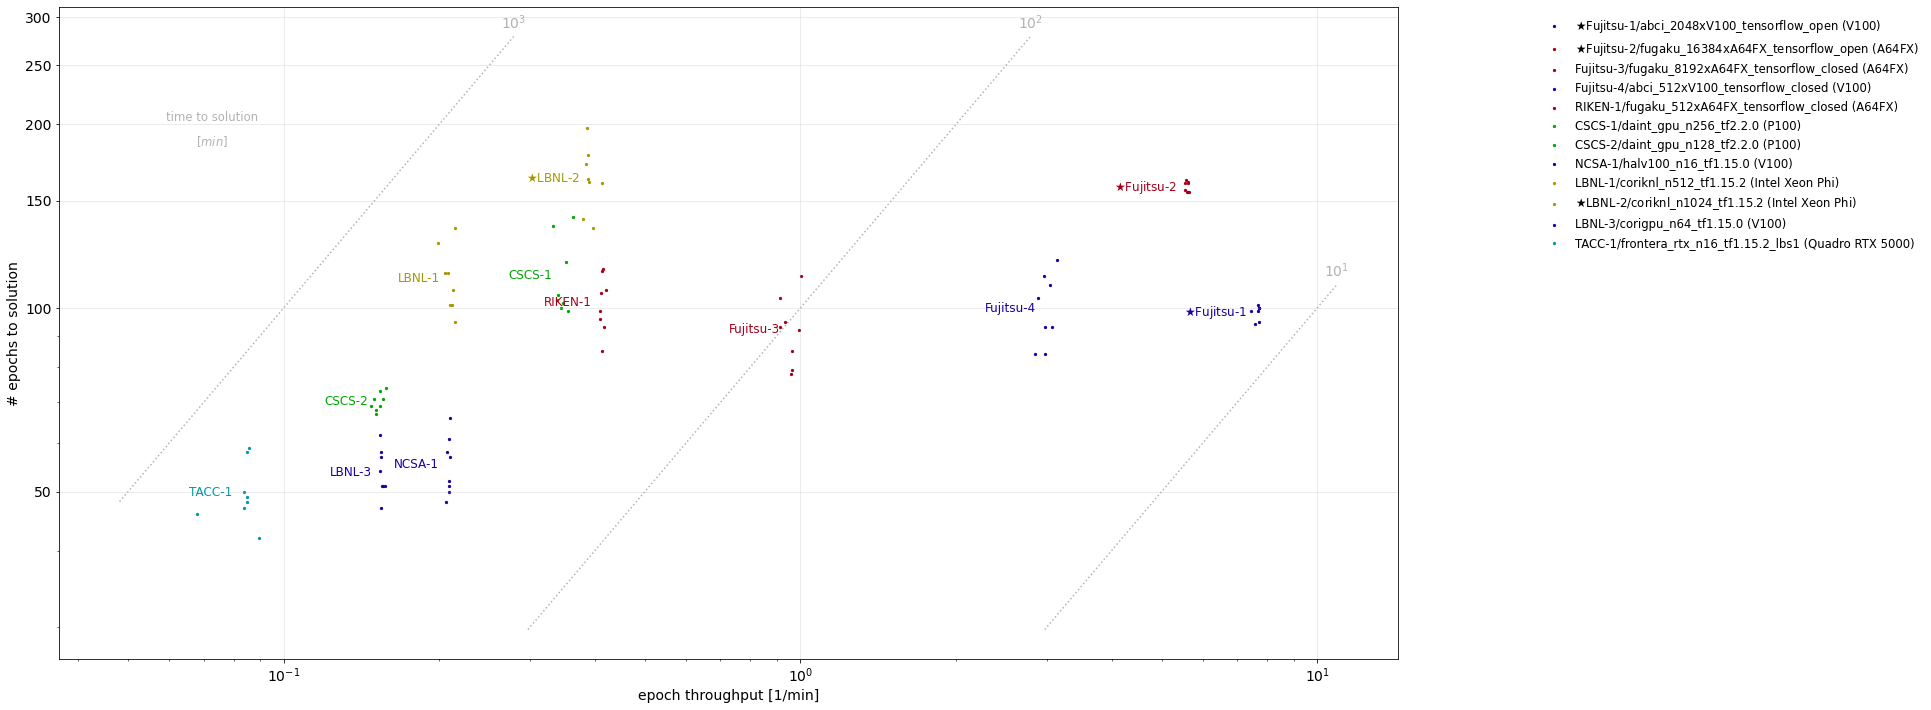

In [47]:
fig, ax = plt.subplots(ncols=1,
                       figsize=(24, 12))

# x_label = 'batch size'
# x_key = 'global_batch_size'

y_label = '# epochs to solution'
y_key = 'run_stop_epoch'
y_transform = None

x_label = 'epoch throughput [1/min]'
x_key = 'run_epoch_throughput'
x_transform = lambda t: t*60.
    
plot_all_submissions_scatter(x_key=x_key, x_label=x_label, x_transform=x_transform, #secondary_x_label=secondary_x_label, secondary_x_key=secondary_x_key, 
                             y_key=y_key, y_label=y_label, y_transform=y_transform, 
                             sharey=True, axis_scale='loglog', color_label=accelerator_short_label, ax=ax)

ax.yaxis.set_major_locator(plt.AutoLocator())
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

## All 4 of batch size, # accelerators, epoch scaling and compute throughput jointly displayed in a 2x2 matrix with shared x-/y-axes

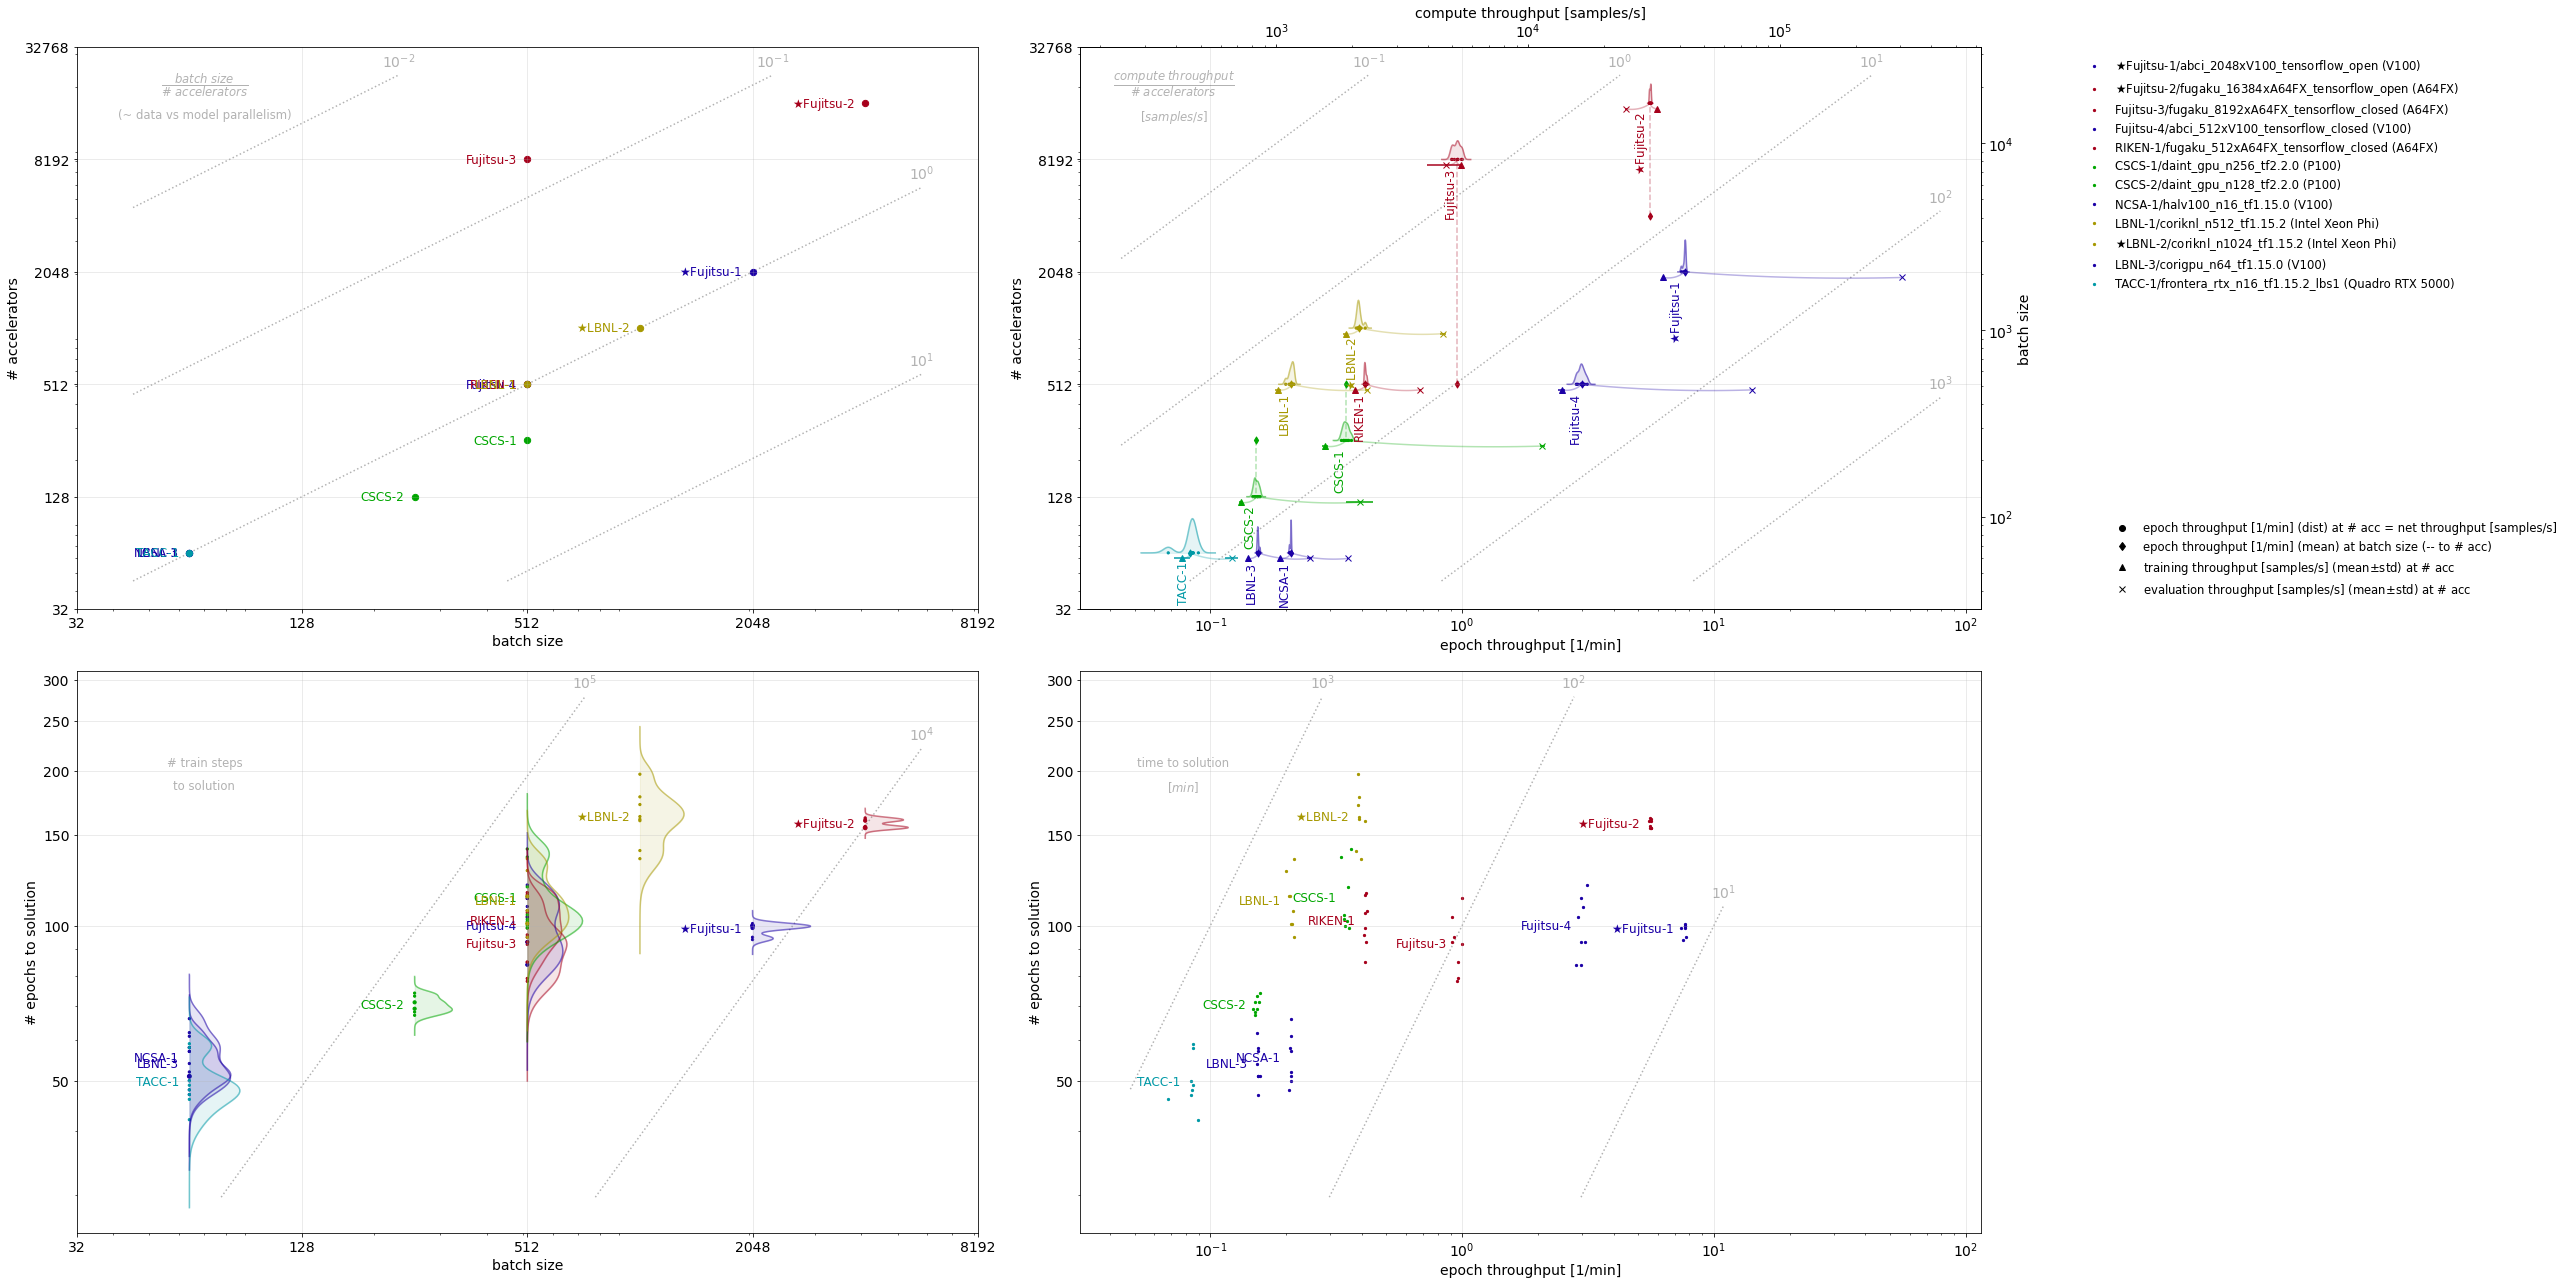

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=2, #                       sharex=True, sharey=True, #sharex=True, 
                       figsize=(36, 18))

if benchmark.round == 'training_results_v0.7':
    filter_submissions = lambda s: s['system']['submitter'] in ['Google', 'NVIDIA'] # ['Alibaba', 'Dell EMC', 'Fujitsu', 'Google', 'Inspur', 'Intel', 'NVIDIA', 'SIAT']
else:
    filter_submissions = lambda s: True

#### 0,0

x_label = 'batch size'
x_key = 'global_batch_size'

y_label = '# accelerators'
y_key = lambda submission_stat: accelerator_number(submission_stat['system'])
y_transform=None

# y_label = 'time to solution [min]'
# y_key = 'run_time'
# y_transform = lambda t: t/60.
    
plot_all_submissions(x_key=x_key, x_label=x_label, 
                     y_key=y_key, y_label=y_label, y_transform=y_transform, 
                     level_func='x/y', level_label=(r'$\dfrac{batch\ size}{\#\ accelerators}$', r'(~ data vs model parallelism)'),
                     sharey=True, axis_scale='loglog', color_label=accelerator_short_label,
                     format_y_axis_as_x_axis=True, 
                     filter_submissions=filter_submissions, ax=ax[0,0])

#### 0,1

secondary_y_label = 'batch size'
secondary_y_legend_label = 'epoch throughput [1/min] (mean) at batch size (-- to # acc)'
secondary_y_key = 'global_batch_size'
secondary_y_marker = 'd'

y_label = '# accelerators'
y_key = lambda submission_stat: accelerator_number(submission_stat['system'])

primary_to_secondary_y_transform = lambda a: a*batch_size_to_accelerator_ratio
secondary_to_primary_y_transform = lambda b: b/batch_size_to_accelerator_ratio

# TODO: epoch time

x_label = 'epoch throughput [1/min]'
x_legend_label = 'epoch throughput [1/min] (dist) at # acc = net throughput [samples/s]' if benchmark.round != 'hpc_results_v0.7' or benchmark.name != 'deepcam' else 'epoch throughput [1/min] (dist) at # acc'
x_key = 'run_epoch_throughput'
x_transform = lambda t: t*60.

secondary_x_keys = []
secondary_x_legend_labels = []
secondary_x_transforms = []
secondary_x_markers = []

secondary_x_keys.append('run_train_throughput')
secondary_x_transforms.append(lambda t: t) #*60.
secondary_x_markers.append('^')
secondary_x_legend_labels.append(r'training throughput [samples/s] (mean$\pm$std) at # acc')

secondary_x_keys.append('run_eval_throughput')
secondary_x_transforms.append(lambda t: t) #*60.
secondary_x_markers.append('x')
secondary_x_legend_labels.append(r'evaluation throughput [samples/s] (mean$\pm$std) at # acc')

secondary_x_axis_label = 'compute throughput [samples/s]'

eff_epoch_samples = get_effective_epoch_samples(submissions_stats)
primary_to_secondary_x_transform = lambda et: et*float(eff_epoch_samples)/60. 
secondary_to_primary_x_transform = lambda st: st/float(eff_epoch_samples)*60.

# Epoch throughput w/o initial phase, i.e. staging overhead not shown (makes very minor difference, probably worth mentioning in text rather)

plot_all_submissions_flipped(x_key=x_key, x_label=x_label, x_transform=x_transform, x_legend_label=x_legend_label, 
                             secondary_x_keys=secondary_x_keys, secondary_x_axis_label=secondary_x_axis_label, secondary_x_legend_labels=secondary_x_legend_labels, secondary_x_transforms=secondary_x_transforms, secondary_x_markers=secondary_x_markers,
                             primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform,
                             y_key=y_key, y_label=y_label,
                             secondary_y_key=secondary_y_key, secondary_y_label=secondary_y_label, secondary_y_legend_label=secondary_y_legend_label, secondary_y_marker=secondary_y_marker, 
                             primary_to_secondary_y_transform=primary_to_secondary_y_transform, secondary_to_primary_y_transform=secondary_to_primary_y_transform, 
                             sharey=False, axis_scale='loglog', color_label=accelerator_short_label,
                             filter_submissions=filter_submissions, ax=ax[0,1])

### 1,0

x_label = 'batch size'
x_key = 'global_batch_size'

# x_label = '# accelerators'
# x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

y_label = '# epochs to solution'
y_key = 'run_stop_epoch'
y_transform = None

plot_all_submissions(x_key=x_key, x_label=x_label, 
                     y_key=y_key, y_label=y_label, y_transform=y_transform, 
                     level_func='y/x', level_label=(r'# train steps', r'to solution'), 
                     level_transform=(lambda l, s: l*s['train_samples'], lambda l, s: l/s['train_samples']),
                     sharey=True, axis_scale='loglog', color_label=accelerator_short_label, 
                     filter_submissions=filter_submissions, ax=ax[1,0])

ax[1,0].yaxis.set_major_locator(plt.AutoLocator())
ax[1,0].yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

### 1,1

# x_label = 'batch size'
# x_key = 'global_batch_size'

y_label = '# epochs to solution'
y_key = 'run_stop_epoch'
y_transform = None

x_label = 'epoch throughput [1/min]'
x_key = 'run_epoch_throughput'
x_transform = lambda t: t*60.
    
plot_all_submissions_scatter(x_key=x_key, x_label=x_label, x_transform=x_transform, #secondary_x_label=secondary_x_label, secondary_x_key=secondary_x_key, 
                             y_key=y_key, y_label=y_label, y_transform=y_transform, 
                             sharey=True, axis_scale='loglog', color_label=accelerator_short_label, 
                             filter_submissions=filter_submissions, ax=ax[1,1])

ax[1,1].yaxis.set_major_locator(plt.AutoLocator())
ax[1,1].yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[0,0].set_ylim(ax[0,1].get_ylim())

ax[1,1].set_xlim(ax[0,1].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())

ax[0,0].legend().set_visible(False)
# ax[0,1].legend().set_visible(False)
ax[1,0].legend().set_visible(False)
ax[1,1].legend().set_visible(False)

fig.tight_layout()


In [49]:
# # x_label = 'batch size'
# # x_key = 'global_batch_size'

# x_label = '# accelerators'
# x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

# y_label = 'epoch throughput [1/min]'
# y_key = 'run_epoch_throughput'
# y_transform = lambda t: t*60.
    
# plot_all_submissions(x_key=x_key, x_label=x_label, 
#                      y_key=y_key, y_label=y_label, y_transform=y_transform, 
#                      sharey=True, axis_scale='loglog', color_label=accelerator_short_label)

In [50]:
# secondary_x_label = 'batch size'
# secondary_x_key = 'global_batch_size'

# x_label = '# accelerators'
# x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

# primary_to_secondary_x_transform = lambda a: a 
# secondary_to_primary_x_transform = lambda b: b

# y_label = 'epoch throughput per accelerator [1/min]'
# y_key = lambda submission_stat: submission_stat['run']['run_stop_epoch']/(submission_stat['run']['run_time']*accelerator_number(submission_stat['system']))
# y_transform = lambda t: t*60.

# plot_all_submissions(x_key=x_key, x_label=x_label, 
#                      secondary_x_label=secondary_x_label, secondary_x_key=secondary_x_key, 
#                      primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform,
#                      y_key=y_key, y_label=y_label, y_transform=y_transform,
#                      level_func='x*y', level_label=(r'epoch throughput', r'[1/min]$'),
#                      sharey=True, axis_scale='loglog', color_label=accelerator_short_label)

In [51]:
# x_label = '# accelerators'
# x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

# plot_all_submissions(x_key=x_key, x_label=x_label, 
#                      y_key=y_key, y_label=y_label, y_transform=y_transform, 
#                      sharey=True, axis_scale='loglog', color_label=accelerator_short_label)

In [52]:
# x_label = '# accelerators'
# x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

# secondary_x_label = 'batch size'
# secondary_x_key = 'global_batch_size'

# plot_all_submissions(x_key=x_key, x_label=x_label, 
#                      secondary_x_label=secondary_x_label, secondary_x_key=secondary_x_key, 
#                      primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform,
#                      y_key=y_key, y_label=y_label, y_transform=y_transform, 
#                      sharey=True, axis_scale='loglog', color_label=accelerator_short_label)

## Compute budget & utilization surrogates

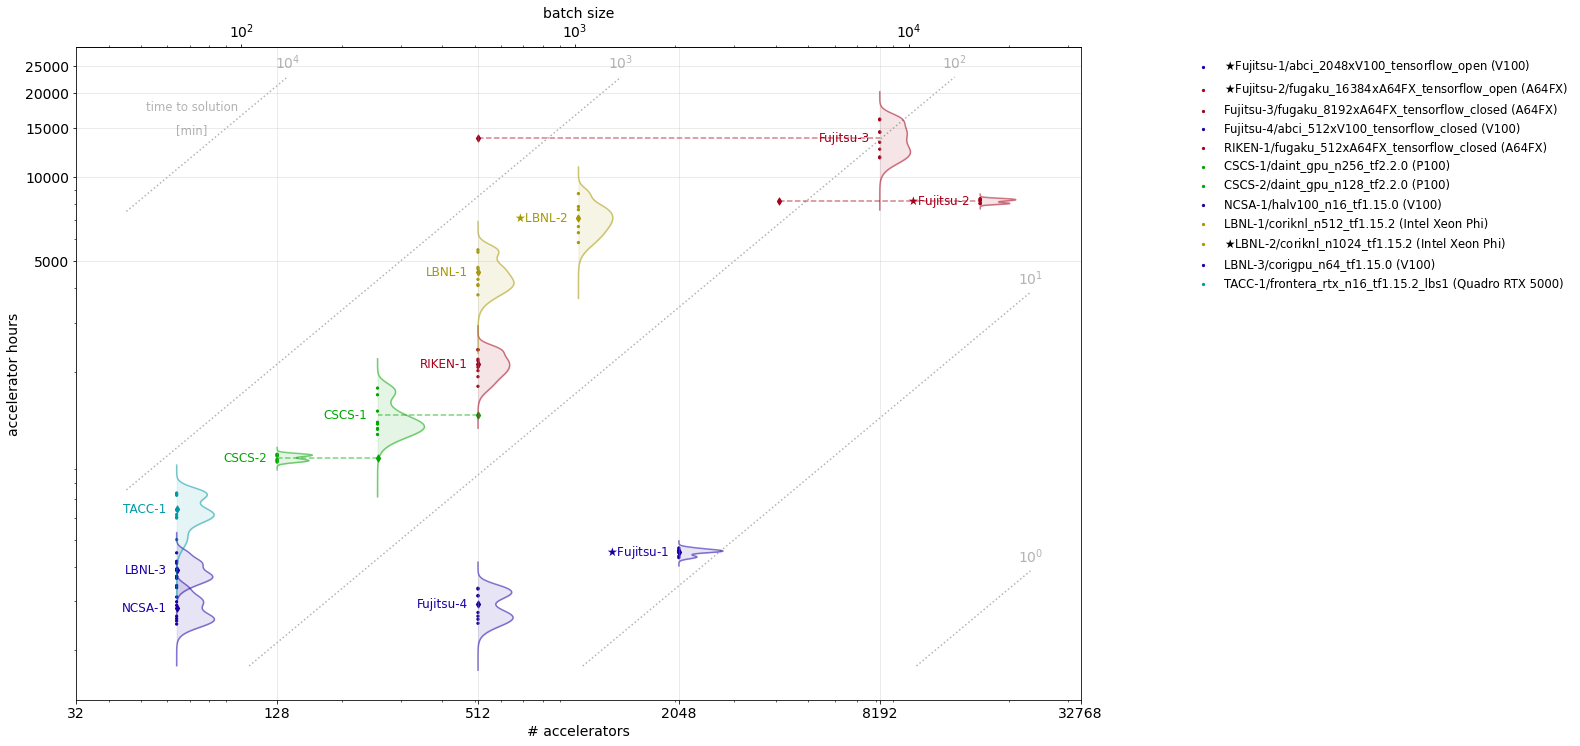

In [53]:
fig, ax = plt.subplots(ncols=1,
                       figsize=(18, 12))

secondary_x_label = 'batch size'
secondary_x_key = 'global_batch_size'
secondary_x_marker = 'd'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

primary_to_secondary_x_transform = lambda a: a*batch_size_to_accelerator_ratio
secondary_to_primary_x_transform = lambda b: b/batch_size_to_accelerator_ratio
x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

y_label = 'accelerator hours'
y_key = get_accelerator_hours
y_transform = None

level_func='y/x' 
level_label=(r'time to solution', r'[min]')
level_transform=(lambda t: t*60, lambda t: t/60) # set to h to min conversion

plot_all_submissions(x_key=x_key, x_label=x_label, 
                     secondary_x_label=secondary_x_label, secondary_x_key=secondary_x_key, secondary_x_marker=secondary_x_marker,
                     primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform,
                     y_key=y_key, y_label=y_label, y_transform=y_transform, 
                     sharey=True, axis_scale='loglog', color_label=accelerator_short_label,
                     level_func=level_func, level_label=level_label, level_transform=level_transform, ax=ax)

ax.yaxis.set_major_locator(plt.AutoLocator())
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))


In [54]:
if benchmark.round == 'training_results_v0.7':
    fig, ax = plt.subplots(ncols=1,
                           figsize=(18, 12))
    plot_all_submissions(x_key=x_key, x_label=x_label, 
                         secondary_x_label=secondary_x_label, secondary_x_key=secondary_x_key, secondary_x_marker=secondary_x_marker,
                         primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform,
                         y_key=y_key, y_label=y_label, y_transform=y_transform, 
                         sharey=True, axis_scale='loglog', color_label=accelerator_short_label,
                         level_func=level_func, level_label=level_label, level_transform=level_transform,
                         filter_submissions=lambda s: s['system']['submitter'] not in ['Intel'], ax=ax)
    ax.yaxis.set_major_locator(plt.AutoLocator())
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

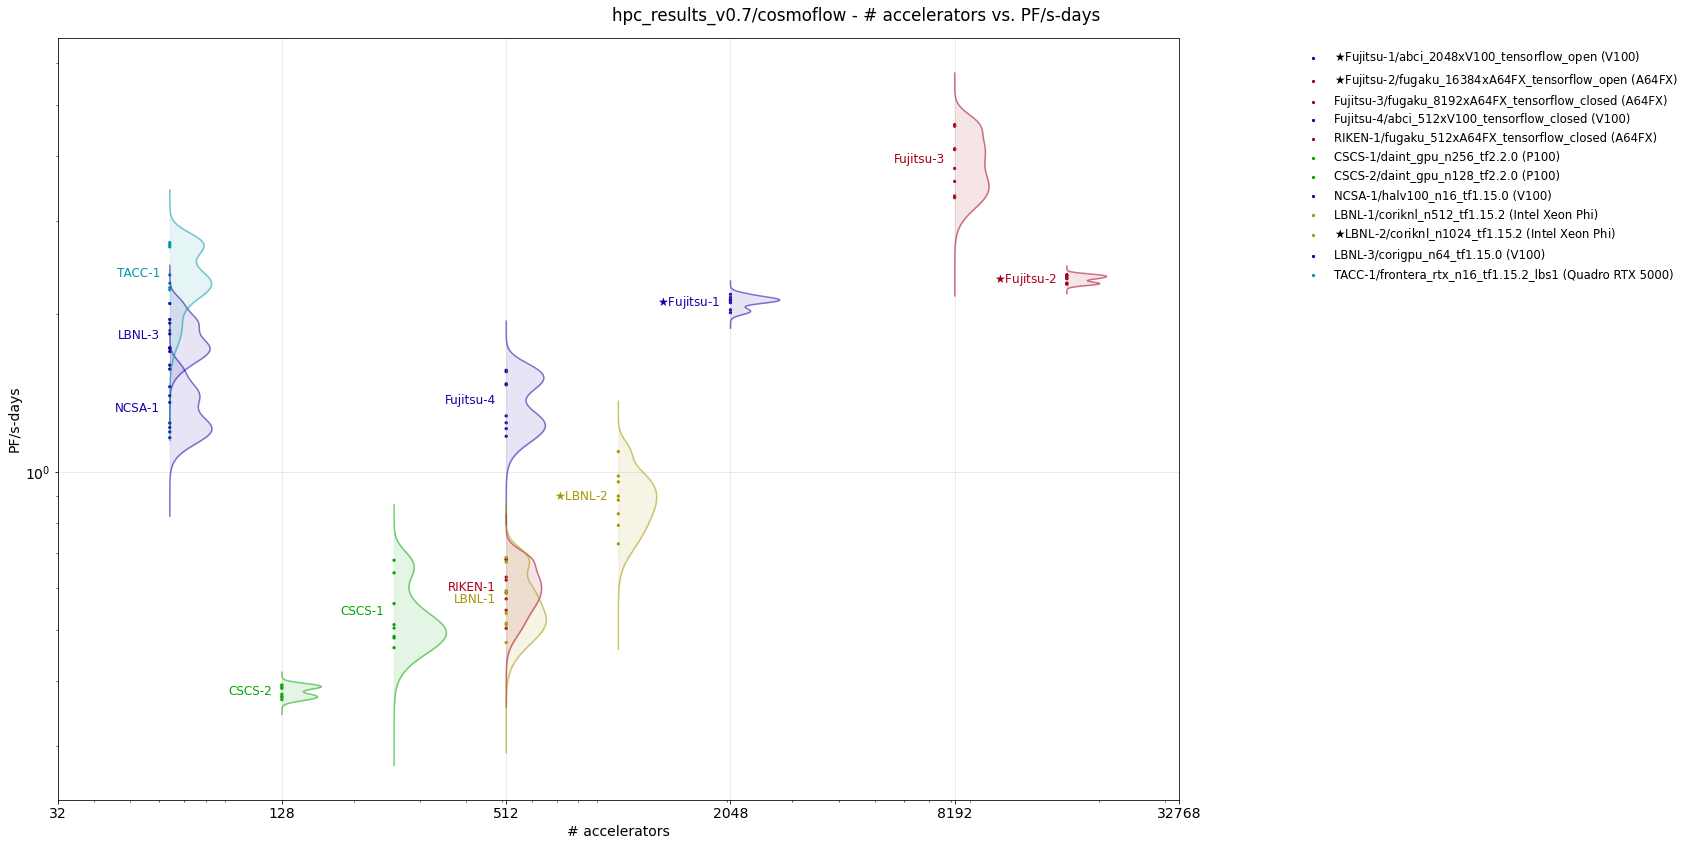

In [55]:
# Utilization surrogate based on published peak accelerator flop/s 
if benchmark.round == 'hpc_results_v0.7':
    # x_label = 'batch size'
    # x_key = 'global_batch_size'

    x_label = '# accelerators'
    x_key = lambda submission_stat: accelerator_number(submission_stat['system'])
    
    y_label = 'PF/s-days'
    y_key = get_pflopsdays
    y_transform = None

    plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, axis_scale='loglog', color_label=accelerator_short_label)

In [56]:
submissions_stats_df = pd.DataFrame.from_dict(submissions_stats, orient='index').sort_values(['division'])

In [57]:
def visualize_submissions_by_opt(submissions_stats_df_opt_vis, sort_keys=['global_batch_size']):
    if benchmark.round == 'training_results_v0.7':
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'closed') & (submissions_stats_df_opt_vis['opt_name'] == 'sgd')].drop(columns=[c for c in submissions_stats_df_opt_vis.columns if c.startswith('lars_')]).sort_values(sort_keys))
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'closed') & (submissions_stats_df_opt_vis['opt_name'] == 'lars')].drop(columns=[c for c in submissions_stats_df_opt_vis.columns if c.startswith('sgd_') or c == 'model_bn_span' or c == 'opt_learning_rate_warmup_epochs']).sort_values(sort_keys))
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'open')].sort_values(sort_keys))
    else:
        display(submissions_stats_df_opt_vis.sort_values(['division'] + sort_keys))

### Runtime statistics

In [58]:
submissions_stats_df_run_mean = submissions_stats_df['runs'].apply(lambda expt: pd.DataFrame.from_dict(expt).mean()).add_suffix('.mean')
submissions_stats_df_run_mean.index = submissions_stats_df.index
submissions_stats_df_run_std = submissions_stats_df['runs'].apply(lambda expt: pd.DataFrame.from_dict(expt).std()).add_suffix('.std')
submissions_stats_df_run_std.index = submissions_stats_df.index
submissions_stats_df_run = submissions_stats_df_run_mean.join(submissions_stats_df_run_std)
submissions_stats_df_run = submissions_stats_df_run[sorted(submissions_stats_df_run.columns)]
for c in submissions_stats_df_run.columns: # transform units from seconds to minutes
    if 'throughput' in c:
        submissions_stats_df_run[c] *= 60.
    elif 'time' in c:
        submissions_stats_df_run[c] /= 60.
submissions_stats_df_run.index = submissions_stats_df.index
submissions_stats_df_run

submissions_stats_df_run_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'opt_opts', 'system']).join(submissions_stats_df_run).set_index('submission_label').sort_values(['division', 'global_batch_size'])
submissions_stats_df_run_vis
#visualize_submissions_by_opt(submissions_stats_df_run_vis)

,global_batch_size,opt_name,train_samples,eval_samples,division,run_eff_epoch_samples.mean,run_eff_epoch_samples.std,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_time.mean,...,run_staging_throughput.mean,run_staging_throughput.std,run_staging_time.mean,run_staging_time.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std,run_train_throughput.mean,run_train_throughput.std
submission_label,,,,,,,,,,,,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,64,SGD,262144,65536,closed,327680.0,0.0,0.208629,0.001208,4.793341,...,NaN,NaN,NaN,NaN,55.4,7.691265,265.762397,36.645978,6.208302e+04,432.728110
LBNL-3/corigpu_n64_tf1.15.0,64,SGD,262144,65536,closed,327680.0,0.0,0.155718,0.002756,6.423612,...,1.991812e+04,6.117285e+02,16.466193,0.537156,54.9,6.723921,369.382803,45.212997,4.661783e+04,825.106742
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,64,SGD,262144,65536,closed,327680.0,0.0,0.084381,0.006262,11.919348,...,NaN,NaN,NaN,NaN,50.1,6.999206,597.267820,91.651033,2.564540e+04,1955.611952
CSCS-2/daint_gpu_n128_tf2.2.0,256,SGD,262144,65536,closed,327680.0,0.0,0.152946,0.003879,6.542012,...,NaN,NaN,NaN,NaN,70.1,3.381321,458.855033,25.933043,4.352738e+04,916.960189
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,512,SGD,262144,65536,closed,327680.0,0.0,0.950098,0.031777,1.053572,...,8.586962e+04,1.533524e+04,3.951318,0.859693,93.0,15.040686,102.769162,16.563476,3.227834e+05,2704.858624
Fujitsu-4/abci_512xV100_tensorflow_closed,512,SGD,262144,65536,closed,327680.0,0.0,2.983617,0.086206,0.335415,...,4.017504e+05,8.809114e+04,0.903350,0.444555,99.7,14.772723,34.380798,4.348638,8.163911e+05,24558.545948
RIKEN-1/fugaku_512xA64FX_tensorflow_closed,512,SGD,262144,65536,closed,327680.0,0.0,0.416431,0.011804,2.402994,...,2.111086e+05,1.419529e+04,1.558698,0.107613,102.5,12.195172,248.877693,32.441916,1.243193e+05,3853.332861
CSCS-1/daint_gpu_n256_tf2.2.0,512,SGD,262144,65536,closed,327680.0,0.0,0.345447,0.009941,2.896907,...,NaN,NaN,NaN,NaN,111.0,17.044061,321.657435,47.800929,9.369390e+04,2746.673799
LBNL-1/coriknl_n512_tf1.15.2,512,SGD,262144,65536,closed,327680.0,0.0,0.210792,0.005345,4.746833,...,1.817332e+08,2.303173e+07,0.001828,0.000222,113.8,18.966637,542.178053,91.757486,6.139779e+04,1684.072202


### Optimizer convergence

In [59]:
submissions_stats_df_opt = pd.json_normalize(submissions_stats_df['opt_opts'])
submissions_stats_df_opt.index = submissions_stats_df.index
submissions_stats_df_opt = submissions_stats_df[['global_batch_size', 'opt_name']].join(submissions_stats_df_opt) #.add_prefix('opt.')

submissions_stats_df_opt_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'global_batch_size', 'opt_name', 'opt_opts', 'system']).join(submissions_stats_df_run[['run_stop_epoch.mean', 'run_stop_epoch.std']]).join(submissions_stats_df_opt).set_index('submission_label')
visualize_submissions_by_opt(submissions_stats_df_opt_vis, sort_keys=['global_batch_size'])

,train_samples,eval_samples,division,run_stop_epoch.mean,run_stop_epoch.std,global_batch_size,opt_name,opt_base_learning_rate,opt_learning_rate_warmup_epochs,opt_learning_rate_warmup_factor,opt_learning_rate_decay_boundary_epochs,opt_learning_rate_decay_factor
submission_label,,,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,262144,65536,closed,55.4,7.691265,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25
LBNL-3/corigpu_n64_tf1.15.0,262144,65536,closed,54.9,6.723921,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,262144,65536,closed,50.1,6.999206,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25
CSCS-2/daint_gpu_n128_tf2.2.0,262144,65536,closed,70.1,3.381321,256,SGD,0.004,4.0,4.000,"[32, 64]",0.25
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,262144,65536,closed,93.0,15.040686,512,SGD,0.008,4.0,0.125,"[32, 64]",0.25
Fujitsu-4/abci_512xV100_tensorflow_closed,262144,65536,closed,99.7,14.772723,512,SGD,0.008,4.0,0.125,"[32, 64]",0.25
RIKEN-1/fugaku_512xA64FX_tensorflow_closed,262144,65536,closed,102.5,12.195172,512,SGD,0.008,4.0,0.125,"[32, 64]",0.25
CSCS-1/daint_gpu_n256_tf2.2.0,262144,65536,closed,111.0,17.044061,512,SGD,0.008,4.0,8.000,"[32, 64]",0.25
LBNL-1/coriknl_n512_tf1.15.2,262144,65536,closed,113.8,18.966637,512,SGD,0.008,4.0,8.000,"[32, 64]",0.25


### System performance (compute)

In [60]:
pd.set_option("display.max_columns", 0)
submissions_stats_df_system = pd.json_normalize(submissions_stats_df['system']).add_prefix('system.')
submissions_stats_df_system.index = submissions_stats_df.index

submissions_stats_df_system_run_vis = \
    submissions_stats_df_run[['run_epoch_throughput.mean','run_epoch_throughput.std']].join(submissions_stats_df_system)
submissions_stats_df_system_run_vis = \
    submissions_stats_df_run[['run_epoch_throughput.mean','run_epoch_throughput.std']].join(
        submissions_stats_df_system_run_vis.apply(lambda submissions_stat: submissions_stat['run_epoch_throughput.mean':'run_epoch_throughput.std']/
                                                                                                ( float(submissions_stat['system.number_of_nodes'])*
                                                                                                  float(submissions_stat['system.accelerators_per_node'] 
                                                                                                        if int(submissions_stat['system.accelerators_per_node']) > 0 
                                                                                                        else submissions_stat['system.host_processors_per_node']) ), axis=1).rename(columns=lambda s: '_per_accelerator.'.join(s.split('.'))))

submissions_stats_df_system_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'opt_opts', 'system']).join(submissions_stats_df_system_run_vis).join(submissions_stats_df_system).set_index('submission_label')
# visualize_submissions_by_opt(submissions_stats_df_system_vis, sort_keys=['run_epoch_throughput_per_accelerator.mean'])
submissions_stats_df_system_vis.sort_values(['division', 'global_batch_size']) # 'run_epoch_throughput_per_accelerator.mean'])

,global_batch_size,opt_name,train_samples,eval_samples,division,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_throughput_per_accelerator.mean,run_epoch_throughput_per_accelerator.std,system.submitter,system.division,system.system_type,system.status,system.system_name,system.number_of_nodes,system.host_processors_per_node,system.host_processor_model_name,system.host_processor_core_count,system.host_processor_vcpu_count,system.host_processor_frequency,system.host_processor_caches,system.host_processor_interconnect,system.host_memory_capacity,system.host_storage_type,system.host_storage_capacity,system.host_networking,system.host_networking_topology,system.host_memory_configuration,system.accelerators_per_node,system.accelerator_model_name,system.accelerator_host_interconnect,system.accelerator_frequency,system.accelerator_on-chip_memories,system.accelerator_memory_configuration,system.accelerator_memory_capacity,system.accelerator_interconnect,system.accelerator_interconnect_topology,system.cooling,system.hw_notes,system.framework,system.other_software_stack,system.operating_system,system.sw_notes,system.other_software_stack.Cray MPICH,system.other_software_stack.Cray GNU,system.other_software_stack.Cray Python,system.other_software_stack.Horovod,system.other_software_stack.NCCL,system.other_software_stack.cuDNN,system.other_software_stack.CUDA,system.other_software_stack.CUDA Driver,system.other_software_stack.IBM WMLCE,system.other_software_stack.OpenMPI,system.other_software_stack.Cray-MPICH,system.other_software_stack.h5py,system.other_software_stack.horovod,system.other_software_stack.MPICH,system.host_processor_threads_per_core
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,64,SGD,262144,65536,closed,0.208629,0.001208,0.003260,0.000019,NCSA,closed,NaN,onprem,hal_v100_n16_tf1.15.0,16,2,IBM POWER 9 model 2.2,40,160,2.3/3.8 GHz,32/512/10240 KB,X-Bus,256 GB DDR4,GPFS,0,infiniband EDR,,,4,NVIDIA Tesla V100,NVLink2,1.53 GHz,,,16 GB,NVLink2,,Air,,Tensorflow-v1.15.0,NaN,CentOS 7.7,,NaN,NaN,NaN,0.20.0,NaN,NaN,10.1.243,NaN,1.6.2,4.0.3,NaN,NaN,NaN,NaN,NaN
LBNL-3/corigpu_n64_tf1.15.0,64,SGD,262144,65536,closed,0.155718,0.002756,0.002433,0.000043,LBNL,closed,NaN,onprem,corigpu_n64_tf1.15.0,8,2,Intel Xeon Gold 6148,20,40,2.4 GHz,,,384 GB DDR4,on-node NVMe storage,930 GB,4 dual-port Mellanox MT27800 (ConnectX-5) EDR ...,,,8,NVIDIA V100,PCIe 3.0,1245 MHz,,,8 GB,NVLink,hybrid cube-mesh,,https://docs-dev.nersc.gov/cgpu/hardware/,Tensorflow 1.15.0,NaN,openSUSE 15.0,,NaN,NaN,NaN,NaN,2.4.8,7.6.5,10.0.130,NaN,NaN,NaN,NaN,2.9.0,0.19.0,3.3.1,NaN
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,64,SGD,262144,65536,closed,0.084381,0.006262,0.001318,0.000098,TACC,closed,Computing Center,available,Frontera-RTX,16,2,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GH,8,16,2.1 GHz,"L1d cache: 32K, L1i cache: 32K, L2 cache: 256...",InfiniBand,128GB (2133 MT/s) DDR4,SSD,144GB /tmp partition on a 240GB SSD,FDR,Fat Tree,8x16GB,4,NVIDIA Quadro RTX 5000,,2100 MHz,16GB GDDR6 / card,,,,,Liquid Submerged : GRC ICE ICEraQ™ system,,tensorflow-gpu 1.15.2,gcc/9.1.0 cuda/10.0 cudnn/7.6.2 nccl/2.4.7 cma...,CentOS Linux release 7.8.2003,Local Batch Size 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
CSCS-2/daint_gpu_n128_tf2.2.0,256,SGD,262144,65536,closed,0.152946,0.003879,0.001195,0.000030,CSCS,closed,NaN,onprem,daint_gpu_n128_tf2.2.0,128,1,Intel(R) Xeon(R) E5-2690 v3 @ 2.60GHz,12,,,,,64 GB,,,Cray Aries routing and communications ASIC (9....,Dragonfly network topology,,1,NVIDIA P100-PCIE-16GB,PCIe 3 x16,1328 MHz,,,16 GB,,,,,TensorFlow 2.2.0,NaN,CLE7 UP02,,7.7.15,20.08,3.8.2.1,0.19.1,2.6.4,7.6.4,10.1.168,440.33.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,512,SGD,262144,65536,closed,0.950098,0.031777,0.000116,0.000004,Fujitsu,closed,datacenter,available,fugaku_8192xA64FX_tensorflow_closed,8192,1,FUJITSU Processor A64FX,48 computing cores + 4 assistant cores (4 CMGs),,2200MHz

In [61]:
submissions_stats_df_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'global_batch_size', 'opt_name', 'opt_opts', 'system']).join(submissions_stats_df_run).join(submissions_stats_df_opt).join(submissions_stats_df_system).set_index('submission_label').sort_values(['division', 'global_batch_size'])
visualize_submissions_by_opt(submissions_stats_df_vis)
# the complete table

,train_samples,eval_samples,division,run_eff_epoch_samples.mean,run_eff_epoch_samples.std,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_time.mean,run_epoch_time.std,run_eval_throughput.mean,run_eval_throughput.std,run_num_evals.mean,run_num_evals.std,run_staging_throughput.mean,run_staging_throughput.std,run_staging_time.mean,run_staging_time.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std,run_train_throughput.mean,run_train_throughput.std,global_batch_size,opt_name,opt_base_learning_rate,opt_learning_rate_warmup_epochs,opt_learning_rate_warmup_factor,opt_learning_rate_decay_boundary_epochs,opt_learning_rate_decay_factor,system.submitter,system.division,system.system_type,system.status,system.system_name,system.number_of_nodes,system.host_processors_per_node,system.host_processor_model_name,system.host_processor_core_count,system.host_processor_vcpu_count,system.host_processor_frequency,system.host_processor_caches,system.host_processor_interconnect,system.host_memory_capacity,system.host_storage_type,system.host_storage_capacity,system.host_networking,system.host_networking_topology,system.host_memory_configuration,system.accelerators_per_node,system.accelerator_model_name,system.accelerator_host_interconnect,system.accelerator_frequency,system.accelerator_on-chip_memories,system.accelerator_memory_configuration,system.accelerator_memory_capacity,system.accelerator_interconnect,system.accelerator_interconnect_topology,system.cooling,system.hw_notes,system.framework,system.other_software_stack,system.operating_system,system.sw_notes,system.other_software_stack.Cray MPICH,system.other_software_stack.Cray GNU,system.other_software_stack.Cray Python,system.other_software_stack.Horovod,system.other_software_stack.NCCL,system.other_software_stack.cuDNN,system.other_software_stack.CUDA,system.other_software_stack.CUDA Driver,system.other_software_stack.IBM WMLCE,system.other_software_stack.OpenMPI,system.other_software_stack.Cray-MPICH,system.other_software_stack.h5py,system.other_software_stack.horovod,system.other_software_stack.MPICH,system.host_processor_threads_per_core
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,262144,65536,closed,327680.0,0.0,0.208629,0.001208,4.793341,0.027947,1.148418e+05,655.346978,55.4,7.691265,NaN,NaN,NaN,NaN,55.4,7.691265,265.762397,36.645978,6.208302e+04,432.728110,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25,NCSA,closed,NaN,onprem,hal_v100_n16_tf1.15.0,16,2,IBM POWER 9 model 2.2,40,160,2.3/3.8 GHz,32/512/10240 KB,X-Bus,256 GB DDR4,GPFS,0,infiniband EDR,,,4,NVIDIA Tesla V100,NVLink2,1.53 GHz,,,16 GB,NVLink2,,Air,,Tensorflow-v1.15.0,NaN,CentOS 7.7,,NaN,NaN,NaN,0.20.0,NaN,NaN,10.1.243,NaN,1.6.2,4.0.3,NaN,NaN,NaN,NaN,NaN
LBNL-3/corigpu_n64_tf1.15.0,262144,65536,closed,327680.0,0.0,0.155718,0.002756,6.423612,0.110142,8.211312e+04,2572.274262,54.9,6.723921,1.991812e+04,6.117285e+02,16.466193,0.537156,54.9,6.723921,369.382803,45.212997,4.661783e+04,825.106742,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25,LBNL,closed,NaN,onprem,corigpu_n64_tf1.15.0,8,2,Intel Xeon Gold 6148,20,40,2.4 GHz,,,384 GB DDR4,on-node NVMe storage,930 GB,4 dual-port Mellanox MT27800 (ConnectX-5) EDR ...,,,8,NVIDIA V100,PCIe 3.0,1245 MHz,,,8 GB,NVLink,hybrid cube-mesh,,https://docs-dev.nersc.gov/cgpu/hardware/,Tensorflow 1.15.0,NaN,openSUSE 15.0,,NaN,NaN,NaN,NaN,2.4.8,7.6.5,10.0.130,NaN,NaN,NaN,NaN,2.9.0,0.19.0,3.3.1,NaN
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,262144,65536,closed,327680.0,0.0,0.084381,0.006262,11.919348,1.027766,4.027192e+04,2735.993713,50.1,6.999206,NaN,NaN,NaN,NaN,50.1,6.999206,597.267820,91.651033,2.564540e+04,1955.611952,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25,TACC,closed,Computing Center,available,Frontera-RTX,16,2,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GH,8,16,2.1 GHz,"L1d cache: 32K, L1i cache: 32K, L2 cache: 256...",InfiniBand,128GB (2133 MT/s) DDR4,SSD,144GB /tmp partition on a 240GB SSD,FDR,Fat Tree,8x16GB,4,NV